# Fraud Detection: Credit Card Transactions <a class='anchor' id='top'></a>
## Author: Oliverius, Miranda

## Table of Contents:

* [Introduction](#intro)
* [Get the Data](#data)
* [Data Overview & Preparation](#overview)
* [Exploratory Data Analysis](#explore)
* [Data Preprocessing](#preprocess)
* [Shortlist Promising Models](#shortlist)
* [Conclusion](#conclusion)
* [Reflections](#reflections)
* [References](#references)
* [Appendices](#appendices)

## Introduction <a class='anchor' id='intro'></a>

### Business Problem

Opportunities for fraud are vast, as credit card information is no longer confined to physical cards but stored in password managers, internet browsers, and mobile payment apps. While it's convenient to pay for groceries with a tap of a smartwatch when a wallet is forgotten, it carries the risk of data misuse by fraudsters for unauthorized purchases.

This fraud strategy & analytics project aims to swiftly detect and prevent fraudulent transactions while balancing this with the need for premium customer service. The customer base values seamless, uninterrupted service with minimal disruptions, making it essential to address fraud without compromising user experience.

### Machine Learning Task

Fraud detection is a classification task, where machine learning models aim to predict categories rather than numeric values. This project will utilize supervised machine learning algorithms, meaning models will be trained on labeled data categorizing transactions as either 'fraudulent' or 'legitimate.

Considering the preferences of the customer base, it is essential to prioritize the accurate detection of fraudulent credit card transactions to protect customers while minimizing unnecessary disruptions to legitimate transactions as the models are trained and evaluated.

### Metrics

Possible outcomes of the classification model's predictions include:

1. True Positive: A fraudulent transaction is correctly identified as fraud
2. True Negative: A legitimate transaction is correctly identified as legitimate
3. False Positive: A legitimate transaction is incorrectly flagged as fraud
4. False Negative: A fraudulent transaction is incorrectly allowed to proceed as legitimate

Models will be evaluated based on accuracy, precision, recall, F1 score, and AUC-ROC:

1. Accuracy: Measures how often the model correctly predicts whether a transaction is fraudulent or legitimate.
2. Precision: Evaluates how accurate the positive predictions are; for transactions flagged as fraud, how often is that flag correct?
3. Recall: Measures how well the model identifies actual fraud; for fraudulent transactions, how often is the fraud detected?
4. F1 Score: The harmonic mean of precision and recall, balancing both metrics, but only reaching a high value if both are strong.
5. AUC-ROC: Measures the model’s ability to distinguish between classes, with values closer to 1 indicating better model performance.

In this case, precision is prioritized to avoid inconveniencing customers with unnecessary transaction blocks or false alarms. It is preferable to allow a small number of false negatives (missed fraud) rather than cause a large number of false positives. As long as accuracy and recall remain at acceptable levels, minimizing false positives is the focus. The AUC-ROC score also provides a measure of the model’s overall classification ability across different thresholds.

## Get the Data <a class='anchor' id='data'></a>

[Click Here to Return to Top](#top)

This dataset was downloaded from Kartik Shenoy's Kaggle, and is described as "a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants" (Shenoy, 2020). Shenoy notes that he utilized the "Sparkov Data Generation | Github tool created by Brandon Harris" to run the simulation and convert the files to a standard format.

### Data Import

To get started, common Python libraries for data manipulation, visualization, machine learning, and metrics should be imported. These libraries provide a more flexible and purpose-driven approach to working with data than using base Python alone.

In [1]:
# load libraries
## *** DATA MANIPULATION ***
import pandas as pd
import numpy as np
import scipy.stats as stats

## *** DATA VISUALIZATION ***
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## *** MACHINE LEARNING ***
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

## *** METRICS ***
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay as cmd

Upfront, a global random seed is set to ensure reproducibility for all subsequent operations that utilize NumPy.

In [2]:
# set random seed for reproducibility
np.random.seed(42)

Next, the data is imported into the notebook to begin exploratory data analysis. The data is in two comma-separated values (CSV) files, which must be placed in the same file location as the notebook for the following code to run properly.

In [3]:
# import data from CSV files
original_train = pd.read_csv('datasets/fraudTrain.csv')
original_test = pd.read_csv('datasets/fraudTest.csv')

Next, combining the original training and test datasets enables a unified train-test split, ensuring that the sampling process is representative and that the data distribution is consistent across both sets. This approach allows for more robust model evaluation and validation.

In [4]:
# concatenate original training and test sets
cc_transactions = pd.concat([original_train, original_test], axis=0)

<a class='anchor' id='main_a'></a>
Lastly, several variables were saved during the more compute-intensive phases of the project to avoid repeating hyperparameter tuning, metric calculations, and model training. The original code used to compute these variables has been commented out to prevent re-execution but remains in the notebook for reference. If needed, this code can be uncommented to rerun the process when changes are made.

For efficiency and to reduce repository clutter, all variables were stored in a single pickle file. The code used to save the variables is provided in [Appendix A](#appendix_a). Below is the code to load the saved variables before they are utilized throughout the notebook.

In [5]:
# load stored variables
with open('stored_variables.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

### Data Size & Type

The data size and type are checked to understand the scope of the data, the number of missing values, and the data types present. This helps identify initial tasks necessary for data cleaning and preprocessing.

In [6]:
# check data size & type
print(cc_transactions.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1852394 non-null  int64  
 1   trans_date_trans_time  1852394 non-null  object 
 2   cc_num                 1852394 non-null  int64  
 3   merchant               1852394 non-null  object 
 4   category               1852394 non-null  object 
 5   amt                    1852394 non-null  float64
 6   first                  1852394 non-null  object 
 7   last                   1852394 non-null  object 
 8   gender                 1852394 non-null  object 
 9   street                 1852394 non-null  object 
 10  city                   1852394 non-null  object 
 11  state                  1852394 non-null  object 
 12  zip                    1852394 non-null  int64  
 13  lat                    1852394 non-null  float64
 14  long                   1

__Observations:__

__1. There are 1,852,394 total instances.__

An instance refers to an individual record or data row and is sometimes referred to as an "observation". In this case, each instance represents a row of data for one credit card transaction.

__2. There are 23 columns.__

The 'is_fraud' column serves as the target variable that the model aims to predict, while the other columns denote various data features. Features are the input variables used by the model and are commonly referred to as predictors or attributes.

In the data, each column records information about each observation, such as the merchant, category, and amount of each transaction.

__3. Every column has 1,852,394 non-null values, which means that there are no null values in the dataset.__

Null values indicate absent data or data that is not available. Since the dataset contains no null values, there is no need to perform data removal or imputation during preprocessing. However, imputation steps will be included in the preprocessing pipeline so that the model can handle any future data that is introduced with missing values.

__4. The data includes both numeric and categorical data types.__

Columns designated with a "float64" data type contain numeric values that include decimal points, whereas columns labeled with an "int64" data type consist of integers (whole numbers). The "object" data type is used for text data, encompassing alphabetic characters rather than solely numeric values.

Exploratory data analysis should assess whether any numeric data should be treated as categorical. Additionally, since machine learning algorithms typically favor numeric data, categorical variables will need to be encoded to convert them into a numeric format.

__5. The column named "Unnamed: 0" has an unusual designation that lacks context regarding its contents.__

While all features will be examined for their predictive value, the peculiarity of this column name suggests it may not provide meaningful data.

### Data Features & Descriptions

The features of the data are listed below, along with their descriptions. The Kaggle page did not provide an explicit data dictionary, but the column names are straightforward.

1. __Unnamed: 0__: unknown contents, will explore below
2. __trans_date_trans_time__: the date and time of the transaction
3. __cc_num__: the identifying number of the credit card that was used for payment
4. __merchant__: the merchant who was paid
5. __category__: the expense category that describes what the transaction was for
6. __amt__: the amount of the transaction
7. __first__: the first name of the cardholder
8. __last__: the last name of the cardholder
9. __gender__: the gender of the cardholder
10. __street__: the street address of the cardholder
11. __city__: the city of the cardholder
12. __state__: the state of the cardholder
13. __zip__: the zip code of the cardholder
14. __lat__: the latitude of the cardholder's address
15. __long__: the longitude of the cardholder's address
16. __city_pop__: the population of the city associated with the cardholder
17. __job__: the cardholder's occupation
18. __dob__: the cardholder's date of birth
19. __trans_num__: a unique identifier for the transaction
20. __unix_time__: Unix time is "the number of seconds since the Unix epoch" and serves as a "standard for time representation in many computing systems." (Stevens, 1998)
21. __merch_lat__: the latitude of the merchant
22. __merch_long__: the longitude of the merchant
23. __is_fraud__: a binary indicator denoting whether a transaction is fraudulent (1) or legitimate (0)

Next, the first five rows of data are viewed with the data descriptions in mind before documenting initial observations.

In [7]:
# display the first five rows of data
cc_transactions.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


__Observations:__

__1. The "Unnamed: 0" variable just contains zero-based index numbers for each transaction.__

Due to the concatenation of the original train and test sets, the combined dataset likely repeats index numbers in this column. This information holds no predictive value, so this feature will be dropped during feature selection.

__2. The "trans_date_trans_time" variable holds details about several time units.__

Feature engineering can derive different components from the timestamp values, such as the month, day of the week, or time of day, to investigate whether these temporal factors can help predict whether a transaction is fraudulent.

__3. The "cc_num" and "zip" variables are categorical variables stored as numeric values.__

They should be treated as categorical during exploratory data analysis and any data preprocessing tasks if they are used as predictive features.

__4. The "unix_time" variable provides a second lens for viewing time-based data.__

The inclusion of both the "timestamp" and "unix_time" variables allows for a comprehensive exploration of time-based data, but careful feature selection will be essential to retain only the most informative features and avoid unnecessary dimensionality in the model inputs.

__5. The "is_fraud" variable is already in a binary numeric format.__

This variable will not require any transformation to be in the desired format for model training.

### Label Attribute

The goal is to identify fraudulent credit card transactions. Per a review of the feature descriptions, "is_fraud" is the label attribute, providing a binary classification indicating whether each transaction is fraudulent or legitimate.

When evaluating the label attribute, it's crucial to assess whether the data is balanced. Class imbalance occurs when one class has a significantly higher number of observations than another. In scenarios like fraud detection, datasets frequently exhibit imbalance, with a much larger proportion of legitimate transactions compared to fraudulent ones. The impact of such imbalanced datasets in machine learning can be illustrated by the following example:

If a dataset consists of 2% fraudulent transactions and 98% legitimate transactions, an algorithm that predicts every transaction as legitimate would achieve 98% accuracy, despite lacking any real capability to detect fraud.

Examining the value counts for this attribute will help confirm whether the dataset is imbalanced.

In [8]:
# save value counts for the label attribute
class_counts = cc_transactions['is_fraud'].value_counts()

In [9]:
# save value proportions for the label attribute
class_props = round(cc_transactions['is_fraud'].value_counts(normalize=True), 4)

In [10]:
# view summary of counts and proportions for the label attribute
pd.DataFrame({'count': class_counts, 'prop': class_props})

,count,prop
is_fraud,,
0,1842743,0.9948
1,9651,0.0052


Notably, the Sparkov-generated dataset has a significant class imbalance, with 99.48% of the transactions representing legitimate purchases and only 0.52% of the transactiosn representing fraudulent transactions. As noted above, this is representative of what one would expect in the real world, where legitimate transactions are significantly more prevalent than fraudulent ones.

Unfortunately, performing machine learning tasks with a large class imbalance can lead to a model that may have a high rate of overall accuracy without actually exhibiting any aptitude for identifying fraudulent transactions.

Three common methods to combat class imbalance are:
1. Undersampling: This technique involves randomly sampling roughly 'n' observations from the majority class to match the number of observations in the minority class.
    * Pro: The machine learning model utilizes a balanced dataset for training, which helps reduce bias towards the majority class
    * Con: The sampled majority class may not capture important information, potentially leading to a loss of valuable data
2. Oversampling: This method involves sampling the minority class with replacement until it has roughly 'n' observations, matching the majority class count.
    * Pro: It maintains most or all of the data from the majority class, effectively addressing the shortcomings of undersampling
    * Con: This approach can create a dataset that does not accurately reflect the original sample or the real-life population, potentially leading to overfitting
3. Synthetic Minority Over-Sampling Technique (SMOTE): This technique generates synthetic examples of the minority class by interpolating between existing minority instances and their nearest neighbors.
    * Pro: This technique creates a more diverse set of synthetic examples, effectively smoothing the decision boundary and improving model performance
    * Con: The interpolation may lead to the creation of synthetic samples that do not accurately represent the actual minority class, potentially introducing noise (Chawla et al., 2004)

Exploratory data analysis (EDA) will be performed before selecting a method for correcting class imbalance. This approach ensures that the analysis is based on the original data and facilitates an assessment of the characteristics of the imbalance, which will guide the selection of the most appropriate correction method.

### Data Split

To enhance the model's ability to generalize to new data, it is essential to split the dataset into a training set and a test set. The training set consists of the instances used to train the model, while the test set is reserved for evaluating the model's performance on unseen data, specifically its ability to predict fraudulent transactions.

To perform the data split, the label attribute is separated from the predictive features, designating the label attribute as 'X' and the predictive features as 'y.' The resulting label and feature datasets are then divided into training and test sets, allocating 80% for training and 20% for testing.

Any class imbalance correction methods will be applied solely to the training set to ensure that the test set remains a more representative sample, allowing for an accurate assessment of the model's effectiveness.

In [11]:
# store predictive features
X = cc_transactions.drop('is_fraud', axis=1)

In [12]:
# store label attribute
y = cc_transactions['is_fraud']

In [13]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    # allocate 80% to training and 20% to testing
    test_size=0.2,
    # stratify to ensure proportionate amount of each class in both sets
    stratify=y, 
    # set random_state for reproducibility
    random_state=42
)

## Data Overview & Preparation <a class='anchor' id='overview'></a>

[Click Here to Return to Top](#top)

Before determining which features to include in the model, it is essential to conduct a thorough exploration of the data to identify the following:

1. What types of data are present, and how does that influence the exploration and modeling approach?
2. What features can be modified or added through feature engineering to enhance analysis?
3. What insights can be derived from the statistical characteristics of the data?
4. What insights can be gained through data visualization?

Notably, anomalies or outliers will not be removed for this project, as fraudulent activity is often characterized by such irregularities.

Finally, when the data is split, the predictive features are separated from the label attribute. For convenience and efficiency during data exploration, the training data is consolidated into a single data frame.

In [14]:
# combine training data
cc_transactions_train = pd.concat((X_train, y_train), axis=1)

### Studying Attributes

Understanding the types of data in the dataset is crucial for selecting the appropriate descriptive statistics and visualizations for further exploration.

Below, two broad data categories are defined, and each attribute is classified into its corresponding data type:

__1. Categorical data__ refers to non-numeric data that can be grouped based on some qualitative characteristic or trait. This includes the following features:
* Unnamed: 0
* cc_num
* merchant
* category
* first
* last
* gender
* street
* city
* state
* zip
* job
* trans_num

__2. Quantitative data__ refers to data that takes the form of numeric values, where the values hold meaning beyond their order or rank and are measurable. This includes the following features:
* trans_date_trans_time
* amt
* lat
* long
* city_pop
* dob
* unix_time
* merch_lat
* merch_long

As noted above, the 'Unnamed: 0' variable contains indexing information that is irrelevant to the machine learning task. Given the likelihood of additional features being deemed unnecessary after each feature engineering step, an empty list is created to add features to. The entire list will be removed in one step before computing descriptive statistics and generating data visualizations.

In [15]:
# create empty list to collect the names of unnecessary columns
drop_cols = []

In [16]:
# add 'Unnamed: 0' to list of columns to drop
drop_cols.append('Unnamed: 0')

As noted previously, the 'cc_num' and 'zip' variables are categorical variables that are currently stored as numeric values. The following code converts them to the 'object' datatype, allowing them to be treated appropriately for various tasks such as data visualization and encoding.

In [17]:
# define function to convert categorical variables stores as numeric values to 'object' datatype
def convert_to_object(df, cat_cols_stored_as_num = ['cc_num', 'zip']):
    # convert to 'object' datatype
    df[cat_cols_stored_as_num] = df[cat_cols_stored_as_num].astype('object')
    
    # return modified DataFrame
    return df

In [18]:
# use convert_to_object on the training DataFrame
cc_transactions_train = convert_to_object(cc_transactions_train)

### Transaction Indexing

Setting the transaction number as the index for the DataFrame serves several practical purposes. Firstly, it provides a unique identifier for each transaction, making it easy to reference and retrieve specific records throughout the analysis process. This approach enhances the clarity and organization of the dataset, allowing for straightforward tracking of transactions, particularly when evaluating model predictions. Additionally, maintaining the transaction number as the index facilitates efficient data manipulation and integration with model outputs, ensuring that predicted fraudulent transactions can be accurately associated with their respective identifiers.

In [19]:
# define function to set transaction number as index
def set_df_index(df, index='trans_num'):
    # set index
    df.set_index(index, inplace=True)
    
    # return modified DataFrame
    return df

In [20]:
# use set_df_index on training DataFrame
cc_transactions_train = set_df_index(cc_transactions_train)

### Profile Integrity Assessment

Checking for inconsistent user profiles is essential to ensure data integrity and accuracy. Inconsistencies in the user information associated with a credit card number may indicate potential fraud or data entry errors. By identifying any profiles that have conflicting attributes, it is possible to address data quality issues before further analysis or modeling.

In [21]:
# group users by credit card number and aggregate unique counts for profile data
unique_users = cc_transactions_train.groupby('cc_num').agg({
    'first': pd.Series.nunique,
    'last': pd.Series.nunique,
    'street': pd.Series.nunique,
    'city': pd.Series.nunique,
    'state': pd.Series.nunique,
    'zip': pd.Series.nunique
})

# identify credit card numbers with inconsistent profiles
inconsistent_profiles = unique_users[(unique_users['first'] > 1) | 
                                     (unique_users['last'] > 1) | 
                                     (unique_users['street'] > 1) | 
                                     (unique_users['city'] > 1) | 
                                     (unique_users['state'] > 1) | 
                                     (unique_users['zip'] > 1)]

print("Inconsistent profiles with cc_num:")
print(inconsistent_profiles)

Inconsistent profiles with cc_num:
Empty DataFrame
Columns: [first, last, street, city, state, zip]
Index: []


The result 'Empty DataFrame' indicates that there are no inconsistencies found across the user profiles for each credit card number. This suggests that there are no anomalies in the data regarding the specified fields.

Dropping the first name, last name, and street address features is justified, as they do not provide unique information beyond what is available from the credit card number. These features may introduce redundancy in the dataset. These features are dropped in the code below.

Furthermore, the 'cc_num' column will be dropped for two key reasons:
1. While individual card numbers may have some associated risk, they are unique identifiers that typically do not contribute meaningful patterns for generalization in a machine learning model.
2. Including sensitive information like credit card numbers raises significant privacy concerns, and the modeling process should prioritize the protection of this type of data.

However, retaining the city, state, and zip code is worthwhile, as they may still hold predictive value related to geographic patterns in fraudulent activity. This approach helps streamline the analysis while preserving potentially informative features.

In [22]:
# add redundant variables to drop list
for column in ['first', 'last', 'street', 'cc_num']:
    drop_cols.append(column)

### Exploratory Feature Engineering

Feature engineering is the process of creating new features or modifying existing ones to enhance the predictive power of a model. This technique involves transforming raw data into formats that are more suitable for analysis, ultimately aiming to improve the model's accuracy and effectiveness. In this section, feature engineering is applied to the special cc_transactions_train DataFrame used for exploratory analysis, allowing for deeper insights into the data. 

It is important to note that these changes will not affect the actual training and test datasets, which will remain unchanged. Any necessary data manipulation required for modeling will take place in the data preprocessing section, ensuring that the integrity of the original datasets is preserved throughout the analysis process.

#### Date & Time Components

The 'trans_date_trans_time' variable contains a timestamp, which can be examined at various levels of granularity. Time is typically considered a continuous quantitative variable, but analyzing it across different granularities may reveal patterns, such as an increase in fraudulent activity at specific times of day or on certain days of the week.

Currently, the 'trans_date_trans_time' is stored as text. Before conducting further exploratory data analysis, this variable will be converted to a Pandas datetime object to allow for more flexibility in time-related analysis. Then, components of the timestamp, such as year, month, day of the week, and time of day, will be extracted. These components will be treated as categorical variables, similar to the qualitative data. 

After extracting these components, the original 'trans_date_trans_time' and 'unix_time' variables can be removed to reduce dimensionality due to their redundant nature.

In [23]:
# define function for engineering date and time components
def feat_engineer_datetime(df, timestamp='trans_date_trans_time'):
    # convert 'trans_date_trans_time' to datetime format
    df[timestamp] = pd.to_datetime(df[timestamp])
    
    # extract timestamp components
    df['year'] = df[timestamp].dt.year.astype('object')
    df['month'] = df[timestamp].dt.month.astype('object')
    df['day_of_week'] = df[timestamp].dt.dayofweek.astype('object')
    
    # add time of day categories
    df['time_of_day'] = pd.cut(df[timestamp].dt.hour,
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['night', 'morning', 'afternoon', 'evening'],
                                 right=False,
                                 include_lowest=True)
    
    # return modified DataFrame
    return df

In [24]:
# use feat_engineer_datetime on training DataFrame
cc_transactions_train = feat_engineer_datetime(cc_transactions_train)

In [25]:
# add 'trans_date_trans_time' and 'unix_time' to drop list due to redundancy
for column in ['trans_date_trans_time', 'unix_time']:
    drop_cols.append(column)

#### Age

The 'dob' variable can be made more useful for analysis by engineering an 'age' feature. Based on the information from the Kaggle dataset page, the last update occurred on August 5th, 2020, which will be used as the reference date for calculating age in years. Once age extracted from the 'dob' variable, the 'dob' variable is redundant and removing it will reduce dataset dimensionality.

*Note: The reference date is hardcoded for the purposes of this project. If this was extrapolated to new data beyond this project, this date would need to be replaced with a more flexible reference to the current day.*

In [26]:
# define function for engineering age
def feat_engineer_age(df, dob='dob', ref_date = pd.to_datetime('2020-08-05')):
    # convert 'dob' to datetime format
    df[dob] = pd.to_datetime(df[dob])
    
    # compute age by subtracting dob from the reference date, and dividing by days in a year (365.25 accounts for leap years)
    df['age'] = round((ref_date - df[dob]).dt.days / 365.25, 0).astype(int)

    # return modified DataFrame
    return df

In [27]:
# use feat_engineer_age on training DataFrame
cc_transactions_train = feat_engineer_age(cc_transactions_train)

In [28]:
# add 'dob' to drop list due to redundancy
drop_cols.append('dob')

#### Distance

The latitude and longitude values can be used to compute the distance between the credit card user and merchant, which may provide useful insights into potential fraudulent behavior. 

One common method for calculating this distance is the haversine formula, which computes the shortest distance between two points on a sphere (the Earth) by considering their latitudes and longitudes. This distance is often referred to as the great-circle distance.

The haversine formula is based on the spherical geometry of the Earth and provides an accurate estimation of the distance, typically in kilometers or miles, between two locations (Robusto, 1957).

In [29]:
# define function for engineering distance
def feat_engineer_distance(df, user_lat_col='lat', user_lon_col='long', merch_lat_col='merch_lat', merch_lon_col='merch_long'):
    # define Haversine function to compute distance between two points on the globe (in miles)
    # Haversine reference: ChatGPT, which listed NumPy documentation as its reference
    def haversine(lat1, lon1, lat2, lon2):

        # save earth radius in miles
        R = 3959.0  
    
        # convert degrees to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        distance = R * c

        # return distance value
        return distance

    # compute distance and add it to the DataFrame
    df['distance'] = round(haversine(df[user_lat_col], 
                                      df[user_lon_col], 
                                      df[merch_lat_col], 
                                      df[merch_lon_col]), 0).astype(int)

    # return modified DataFrame
    return df

In [30]:
# use feat_engineer_distance on training DataFrame
cc_transactions_train = feat_engineer_distance(cc_transactions_train)

### Column Removal

In [31]:
# define function to drop columns deemed unnecessary
def prelim_drop_cols(df):
    df.drop(drop_cols, axis=1, inplace=True)

    # return modified DataFrame
    return df

In [32]:
# use prelim_drop_cols on training DataFrame
cc_transactions_train = prelim_drop_cols(cc_transactions_train)

## Exploratory Data Analysis <a class='anchor' id='explore'></a>

[Click Here to Return to Top](#top)

### Descriptive Statistics

#### Categorical Features

Keeping the changes to the training dataset features in mind, the following code creates a list of categorical features to be used in an iterative loop computing the number of distinct classes for each categorical feature.

Calculating the number of distinct values for categorical features is a crucial step in exploratory data analysis, providing insights into the dataset's structure and the variety of values present. This process helps identify anomalies and unexpected categories, facilitating data cleaning and preparation. Understanding the distinct values also informs feature selection and modeling decisions, ensuring a comprehensive analysis.

In [33]:
# create list of categorical features
cat_feat_train = ['merchant', 'category', 'gender', 'city', 'state', 'zip', 'job', 'year', 'month', 'day_of_week', 'time_of_day']

In [34]:
# define function to count the number of distinct values for each categorical variable
def get_distinct_count(df, feature):
    return df[feature].nunique()

In [35]:
# summarize distinct counts for each categorical variable
## initialize an empty list to hold results
results = []

# loop through categorical variables, adding the distinct count to the results list
for feature in cat_feat_train:
    count = get_distinct_count(cc_transactions_train, feature)
    results.append((feature, count))

# create a DataFrame from the results list
distinct_count_df = pd.DataFrame(results, columns=['Variable', 'Distinct Count'])

# display the resulting DataFrame, sorting in descending order by distinct count
distinct_count_df.sort_values('Distinct Count', ascending=False)

,Variable,Distinct Count
5,zip,985
3,city,906
0,merchant,693
6,job,497
4,state,51
1,category,14
8,month,12
9,day_of_week,7
10,time_of_day,4
2,gender,2


<a class='anchor' id='main_b'></a>
Cross tabulations are a valuable tool for identifying patterns and trends between categorical variables and the target label, such as detecting correlations between customer attributes and fraudulent transactions. By comparing the counts of categories within a variable against the occurrence of fraud, cross tabulations allow for an easy visualization of these relationships. 

However, for variables with a large number of categories—such as the 985 zip codes or 693 merchants in this dataset—these tables can become difficult to interpret and may obscure patterns or anomalies. Therefore, to maintain clarity, cross tabulations will be used primarily for variables with 15 or fewer categories.

In addition to the counts of fraudulent and non-fraudulent transactions, two additional columns are included to further enhance the analysis:
1. Fraud %: This column indicates the percentage of transactions in each category that were fraudulent. It helps to quickly assess which categories have higher fraud rates relative to others.
2. Relative Risk (RR): Relative risk measures how much more likely fraud is in a given category compared to the overall fraud rate in the dataset (referred to as the global fraud rate). A relative risk greater than 1 suggests that the category is more likely to be associated with fraud compared to the average.

To further enhance clarity, cross tabulations have been filtered to only show categories with a relative risk greater than 1, indicating a higher likelihood of fraud. The full cross tabulations can be viewed in [Appendix B](#appendix_b).

In [36]:
# create list of categorical features with less than 15 distinct categories
cat_less_than_15 = (
    distinct_count_df
    .loc[distinct_count_df['Distinct Count'] < 15]
    .sort_values('Distinct Count', ascending=False)['Variable']
    .tolist()
)

In [37]:
# define function for creating cross tabulations of categorical variables vs. 'is_fraud'
def create_crosstab(df, feature, label):
    # create crosstab with counts
    crosstab = pd.crosstab(df[feature], df[label])
    # add column for the percentage of fraudulent transactions
    crosstab['Fraud %'] = crosstab[1] / crosstab.sum(axis=1) * 100
    # calculate global fraud rate
    global_fraud_rate = df['is_fraud'].mean()
    # add relative risk column (comparison to global fraud rate)
    crosstab['Relative Risk'] = (crosstab['Fraud %'] / global_fraud_rate) / 100
    # return crosstab
    return crosstab

In [38]:
# create cross tabulations for each categorical variable with less than 15 distinct categories
## loop through relevant variables, returning a cross tabulation
for feature in cat_less_than_15:
    cross_tab = create_crosstab(cc_transactions_train, feature, 'is_fraud')
    # filter to categories with relative risk > 1
    filtered_cross_tab = cross_tab[cross_tab['Relative Risk'] > 1]
    display(filtered_cross_tab)
    print()

is_fraud,0,1,Fraud %,Relative Risk
category,,,,
grocery_pos,139253,1759,1.247412,2.394195
misc_net,71372,969,1.339489,2.570923
shopping_net,109675,1758,1.577630,3.027992
shopping_pos,132145,836,0.628661,1.206609


is_fraud,0,1,Fraud %,Relative Risk
month,,,,
1,83070,676,0.807203,1.549289
2,77330,666,0.853890,1.638897
3,113995,742,0.646696,1.241224
5,116692,762,0.648765,1.245194
9,111696,605,0.538731,1.034002
10,109736,684,0.619453,1.188935


is_fraud,0,1,Fraud %,Relative Risk
day_of_week,,,,
2,146146,897,0.610026,1.170841
3,164269,1059,0.640545,1.229417
4,170942,1096,0.637069,1.222745
5,209691,1193,0.565714,1.085792


is_fraud,0,1,Fraud %,Relative Risk
time_of_day,,,,
night,288067,2730,0.938799,1.801866
evening,448266,4249,0.938974,1.802202


is_fraud,0,1,Fraud %,Relative Risk
gender,,,,
M,666872,3787,0.564668,1.083785


is_fraud,0,1,Fraud %,Relative Risk
year,,,,
2019,735730,4165,0.562918,1.080425


Based on the resulting cross tabulations, the following categories (grouped by variable) show a higher percentage of fraudulent transactions compared to the global fraud rate. This indicates that these categories carry a higher relative risk of fraud than others within the dataset. For instance, transactions in the 'shopping-net' category are over three times more likely to be fraudulent than the average fraud risk across all transactions.
* 'category':
    - grocery_pos
    - misc_net
    - shopping_net
    - shopping_pos
* 'month':
    - January
    - February
    - March
    - May
    - September
    - October
* 'day_of_week':
    - Wednesday
    - Thursday
    - Friday
    - Saturday
* 'time_of_day':
    - Night
    - Evening
* 'gender':
    - Male
* 'year':
    - 2019

As noted, displaying full cross tabulations for categorical features with more than 15 categories can lead to results that are difficult to interpret and may not yield useful insights. Instead, the code below returns the number of categories with a relative risk greater than 1. This approach simplifies the analysis, allowing for a clearer understanding of which categories may be associated with a higher likelihood of fraud without overwhelming the viewer with excessive data.

In [39]:
# create list of categorical features with more than 15 distinct categories
cat_more_than_15 = (
    distinct_count_df
    .loc[distinct_count_df['Distinct Count'] > 15]
    .sort_values('Distinct Count', ascending=False)['Variable']
    .tolist()
)

In [40]:
# return number of categories for each variable that show relative risk > 1
# create dictionary to store results
results = {}

## loop through relevant variables, returning count of variables with relative risk > 1
for feature in cat_more_than_15:
    # create the cross tabulation for the current feature
    cross_tab = pd.crosstab(cc_transactions_train[feature], cc_transactions_train['is_fraud'])

    # calculate fraud %
    cross_tab['Fraud %'] = cross_tab[1] / cross_tab.sum(axis=1)
    
    # calculate global fraud rate
    global_fraud_rate = cc_transactions_train['is_fraud'].mean()
    
    # calculate relative risk
    cross_tab['Relative Risk'] = cross_tab['Fraud %'] / global_fraud_rate
    
    # filter to categories with relative risk > 1
    significant_risks = cross_tab[cross_tab['Relative Risk'] > 1]
    
    # count number of categories with relative risk > 1
    num_significant_categories = significant_risks.shape[0]

    # count total number of categories
    total_categories = cross_tab.shape[0]
    
    # store result in dictionary
    results[feature] = (num_significant_categories, total_categories)

# print results
for feature, (num_significant_categories, total_categories) in results.items():
    print(f"Number of categories with relative risk > 1 for {feature}: {num_significant_categories} out of {total_categories} categories")

Number of categories with relative risk > 1 for zip: 501 out of 985 categories
Number of categories with relative risk > 1 for city: 459 out of 906 categories
Number of categories with relative risk > 1 for merchant: 205 out of 693 categories
Number of categories with relative risk > 1 for job: 269 out of 497 categories
Number of categories with relative risk > 1 for state: 27 out of 51 categories


All six features with more than 15 categories contain at least some categories with a relative risk greater than 1. While these counts offer useful insights, they do not necessarily indicate predictive value. 

For example, in a hypothetical scenario where only one accountant exists in the entire dataset and that individual has a fraudulent transaction, the fraud percentage for accountants would be 100%. This would yield a relative risk greater than 1; however, such a scenario alone is insufficient to conclude that being an accountant increases the likelihood of a fraudulent transaction.

The sheer volume of both categories with a relative risk greater than 1 and the number of total categories implies that these features have high cardinality which can add a lot of noise to the data and cause overfitting during model training.

Further, the feature selection process initially included 'zip', 'city', 'merchant', 'job', and 'state' when training a Random Forest model to identify feature importance. Notably, two states were retained in the selected features during the first round of using Random Forest, so 'state' will remain in the dataset for training. However, the other features were not selected and are added to the to 'drop_cols' list to enhance computational efficiency and mitigate high cardinality and noise during preprocessing and training. This echoes best practices for feature selection and model training.

In [41]:
# add high cardinality variables to drop list
for column in ['zip', 'city', 'merchant', 'job']:
    drop_cols.append(column)

#### Quantitative Features

To examine the quantitative features, the Pandas function describe() is utilized to generate a summary of descriptive statistics. While 'lat', 'long', 'merch_lat', and 'merch_long' are classified as continuous variables, descriptive statistics are not produced for them due to the lack of meaningful interpretations.

In [42]:
# format values so that they do not display in scientific notation
## format resource: https://stackoverflow.com/questions/21137150/format-suppress-scientific-notation-from-pandas-aggregation-results
pd.options.display.float_format = '{:.2f}'.format

In [43]:
# create list of quantitative features
num_feat_train = ['amt', 'city_pop', 'age', 'distance']

In [44]:
# check descriptive statistics for quantitative attributes
cc_transactions_train.loc[:, num_feat_train].describe()

,amt,city_pop,age,distance
count,1481915.00,1481915.00,1481915.00,1481915.00
mean,70.02,88640.69,46.80,47.30
std,156.69,301740.42,17.41,18.10
min,1.00,23.00,16.00,0.00
25%,9.65,741.00,33.00,34.00
50%,47.45,2443.00,45.00,49.00
75%,83.04,20328.00,58.00,61.00
max,27390.12,2906700.00,96.00,95.00


__Observations__:

__1. Amount__
- The transactions in the dataset range between \\$1.00 and \\$27,390.12
- 50% of the transactions are below \\$47.45 and 75% are below \\$83.04
- The mean is higher than the median
- Based on the above statistics, it is likely that 'amt' has a right-skewed distributiosn with a number of high outliers

__2. City Population__
- The city populations in the dataset range between 23 and 2,906,700
- 50% of the populations are below 2,443, while 75% are below 20,328
- Based on the above statistics, it is likely that 'city_pop' has a right-skewed distributiosn with a number of high outliers

__3. Age__
- The cardholders in the dataset range between 16 years of age and 96 years of age
- 50% of the cardholders are younger than 45 years of age and 75% are younger than 58 years of age
- The mean and median are relatively close, indicating that the distribution is nearly symmetrical

__4. Distance__
- The distance between user and merchant ranges from 0 miles and 95 miles
- 50% of the distances are less than 49 miles, while 75% are less than 61 miles
- The mean and median are relatively close, indicating that the distribution is nearly symmetrical

### Attribute Correlation

Correlation quantifies linear relationships, indicating how changes in one variable relate to changes in another variable. By assessing correlation, insights can be gained into the strength of any linear relationships among the numeric attributes.

To accomplish this, a correlation matrix is computed, and a gradient is applied to the resulting DataFrame, allowing cells to darken with increasing correlation values.

In [45]:
# compute correlations
corr_matrix = cc_transactions_train.loc[:, num_feat_train].corr(numeric_only=True)

In [46]:
# view entire correlation matrix, styled to highlight DataFrame cells with a gradient based on correlation strength
## gradient resource: https://www.analyticsvidhya.com/blog/2021/06/style-your-pandas-dataframe-and-make-it-stunning/
corr_matrix.style.format(precision=2).background_gradient()

,amt,city_pop,age,distance
amt,1.00,0.01,-0.01,-0.00
city_pop,0.01,1.00,-0.09,0.01
age,-0.01,-0.09,1.00,-0.00
distance,-0.00,0.01,-0.00,1.00


The correlation matrix reveals minimal to no correlation among the amount, city population, age, and distance, with only two values, 0.01 and 0.09, differing from zero. This indicates that the quantitative variables in the dataset do not exhibit multicollinearity, which aligns with expectations, as these variables typically lack a relationship with one another.

### Data Visualization

Data visualization serves as an effective means to identify patterns, anomalies, and relationships within the dataset. Several charts have been created to illustrate the connections between the label attribute ('is_fraud') and various features. To ensure clarity and conciseness, only the most pertinent visualizations are included in this notebook. Presenting every visualization could result in information overload, making it difficult for readers to extract meaningful insights. By concentrating on key charts, this analysis aims to highlight significant patterns and trends while avoiding an overwhelming amount of detail.

#### Sampling Methodology for Visualization

Given the large volume of transactions in the dataset, creating visualizations based on the entire training set is impractical. Instead, a stratified sample of 10,000 transactions has been selected to ensure that the visualizations accurately represent the distribution between fraudulent and legitimate transactions.

*Note: Sampling technique was learned through discussions with ChatGPT, a large language model trained by OpenAI.*

In [47]:
# determine the proportion of each class in the 'is_fraud' column
counts = cc_transactions_train['is_fraud'].value_counts(normalize=True)

In [48]:
# save the total number of samples desired for data visualization
total_samples = 10000

In [49]:
# calculate the total number of samples needed from each class for a total of 10,000
sample_counts = (counts * total_samples).round().astype(int)

In [50]:
# drop any classes with zero samples
sample_counts = sample_counts[sample_counts > 0]

In [51]:
# ensure that total does not exceed the desired sample size
sample_counts = sample_counts[sample_counts < total_samples].fillna(0)

In [52]:
# generate stratified sample based on calculated sample counts
stratified_sample = pd.concat([
    cc_transactions_train[cc_transactions_train['is_fraud'] == fraud_class].sample(n=count, random_state=42)
    for fraud_class, count in sample_counts.items()
])

In [53]:
# display resulting sample value counts
print(stratified_sample['is_fraud'].value_counts())

is_fraud
0    9948
1      52
Name: count, dtype: int64


#### Categorical Variable Visualizations

Initially, a series of count plots and stacked bar plots were created to compare the number of transactions for each categorical variable with fewer than 15 categories, using color to differentiate fraud status. These visualizations revealed that certain categories exhibited higher fraud rates than others. However, the imbalanced nature of the dataset made it difficult to visually compare fraudulent transactions from one category to the next.

To better illustrate the relative risk of fraud associated with each categorical variable, bar plots depicting relative risks were generated. These plots provide a clearer depiction of how specific categories compare to the overall fraud rate in the training set, highlighting those with a relative risk greater than one in magenta. Insights based on these visualizations are provided below.

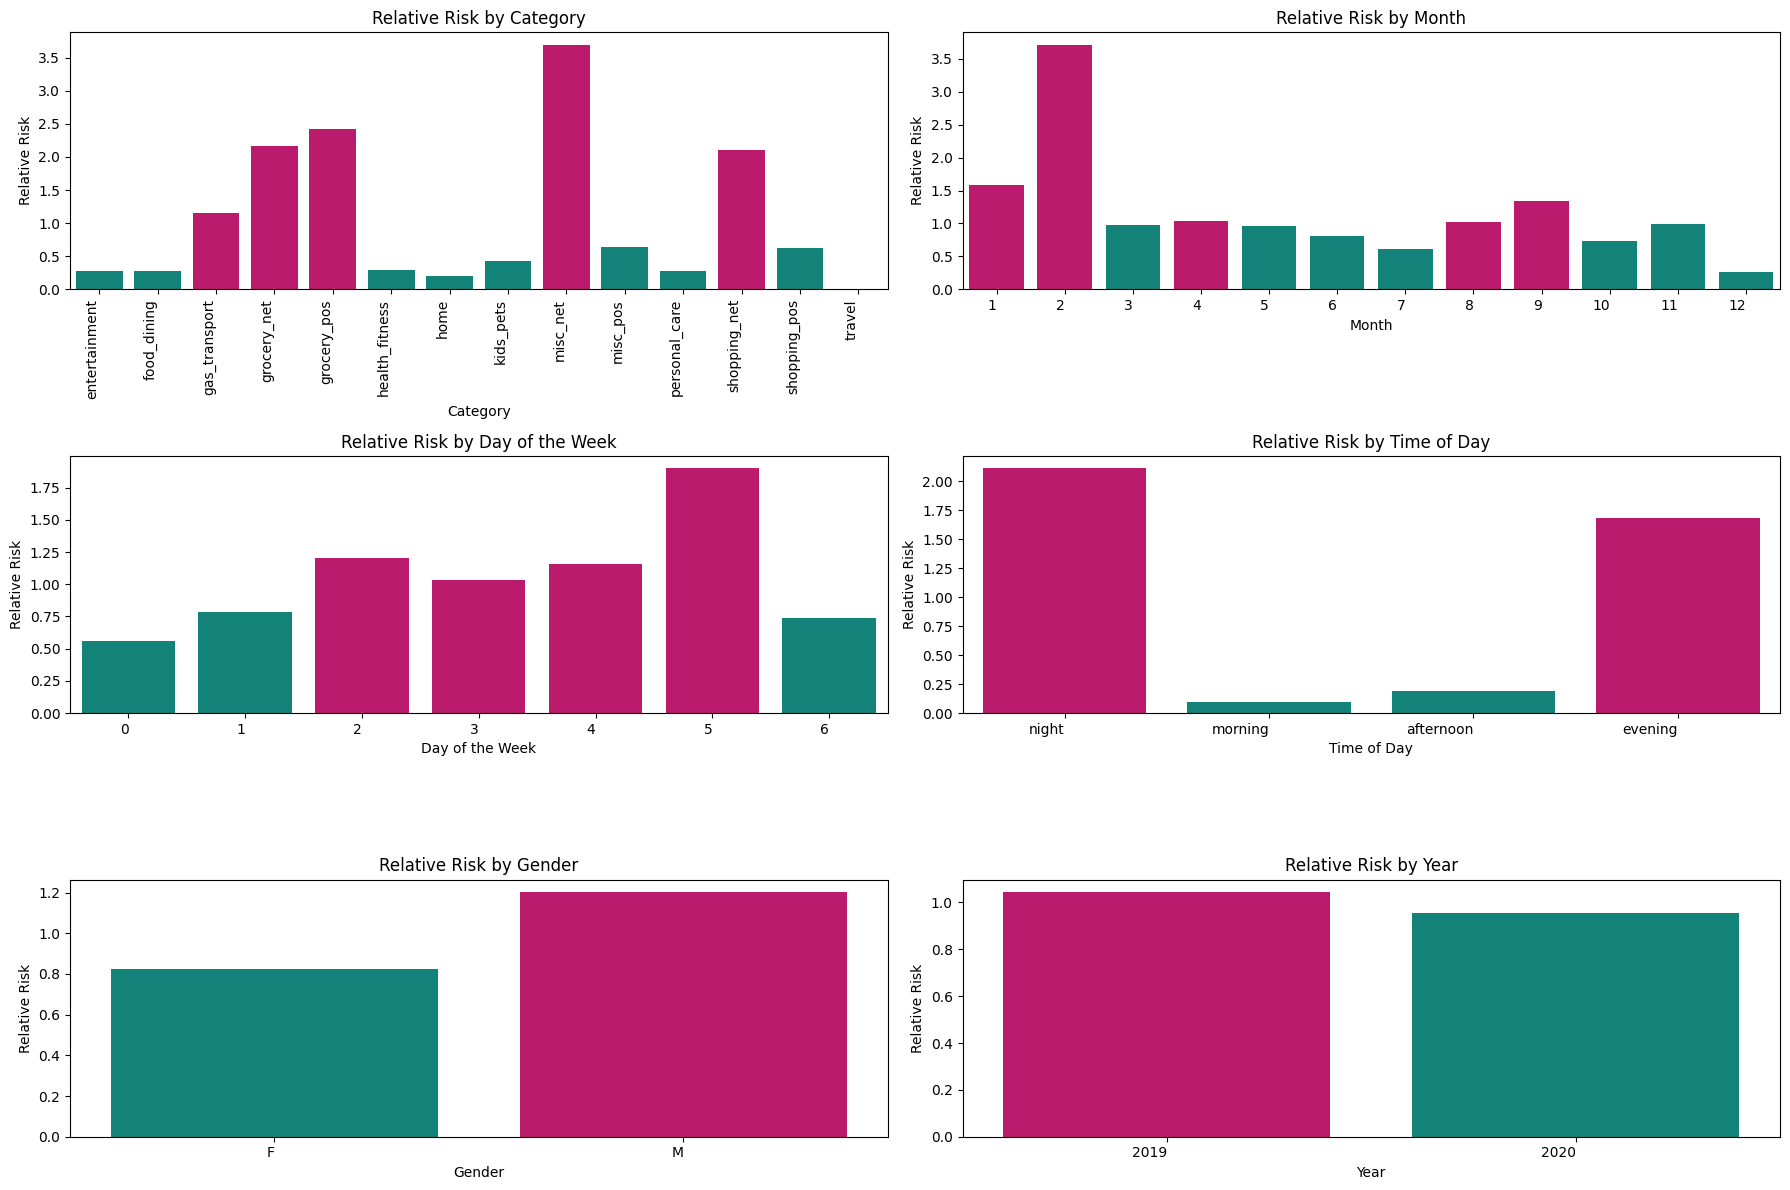

In [54]:
# plot barplots of relative risk for categorical variables with < 15 categories
## set figure size
fig, ax = plt.subplots(3, 2, figsize=(18, 12))

## define function for creating bar plots of relative risk, leveraging previous create_crosstab function
def plot_barplot(feature, ax, rotation, title, xlabel):
    # generate cross tabulation
    feat_crosstab = create_crosstab(stratified_sample, feature, 'is_fraud').reset_index()
    # define color list based on relative risk
    bar_colors = ['#D5006D' if risk > 1 else '#009688' for risk in feat_crosstab['Relative Risk']]
    # plot barplot to compare relative risk by category
    sns.barplot(feat_crosstab, x=feature, y='Relative Risk', hue=feature, palette=bar_colors, legend=False, ax=ax)
    # define ticks
    ax.set_xticks(range(len(feat_crosstab[feature])))
    # rotate tick labels for readability
    ax.set_xticklabels(feat_crosstab[feature], ha='right', rotation=rotation)
    # add labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)

## plot barplots for each feature with < 15 categories
plot_barplot('category', ax[0, 0], 90, 'Relative Risk by Category', 'Category')
plot_barplot('month', ax[0, 1], 0, 'Relative Risk by Month', 'Month')
plot_barplot('day_of_week', ax[1, 0], 0, 'Relative Risk by Day of the Week', 'Day of the Week')
plot_barplot('time_of_day', ax[1, 1], 0, 'Relative Risk by Time of Day', 'Time of Day')
plot_barplot('gender', ax[2, 0], 0, 'Relative Risk by Gender', 'Gender')
plot_barplot('year', ax[2, 1], 0, 'Relative Risk by Year', 'Year')

## set tight layout
plt.tight_layout()

## display plot
plt.show()

__Observations__:

__1. The bar plots reinforce insights from the cross-tabulations, indicating that certain categories exhibit a higher relative risk for fraud.__

For example, both the cross-tabulation summary and the "time of day" plot show that night and evening hours are associated with increased risk.

__2. The visualizations are based on a sub-sample of the training set, leading to potential differences in the categories showing a relative risk greater than one.__

While descriptive statistics for the full training set indicated that January, February, March, May, September, and October had high relative risk, the plots instead identify January, February, April, and August.

__3. This discrepancy between the visualization sub-sample and the full training set underscores the importance of model generalization to new data.__

Insights derived from a smaller sample may not fully apply to a larger population.

Nonetheless, the plots suggest that these six categorical variables possess predictive ability for identifying fraudulent transactions.

#### Quantitative Variable Visualizations

First, histograms were plotted to examine the distribution of each quantitative variable. Both the amount and city population exhibited right-skewed distributions, characterized by high outliers that resulted in minimal representation on the left side of the histograms, leaving the right side appearing nearly blank. The age histogram showed a nearly symmetric distribution with a slight right skew, while the distance plot displayed a roughly symmetric bell shape. These findings align with the expectations established during the analysis of descriptive statistics.

Next, scatterplots were generated to explore the relationships between the quantitative variables. Consistent with the correlation matrix, none of the variables exhibited correlation with one another, and non-linear relationships were not discernible.

Finally, boxplots were created to compare the distributions of each quantitative variable based on the classification of transactions as either fraudulent or legitimate. The boxplots are presented below, accompanied by insights to follow.

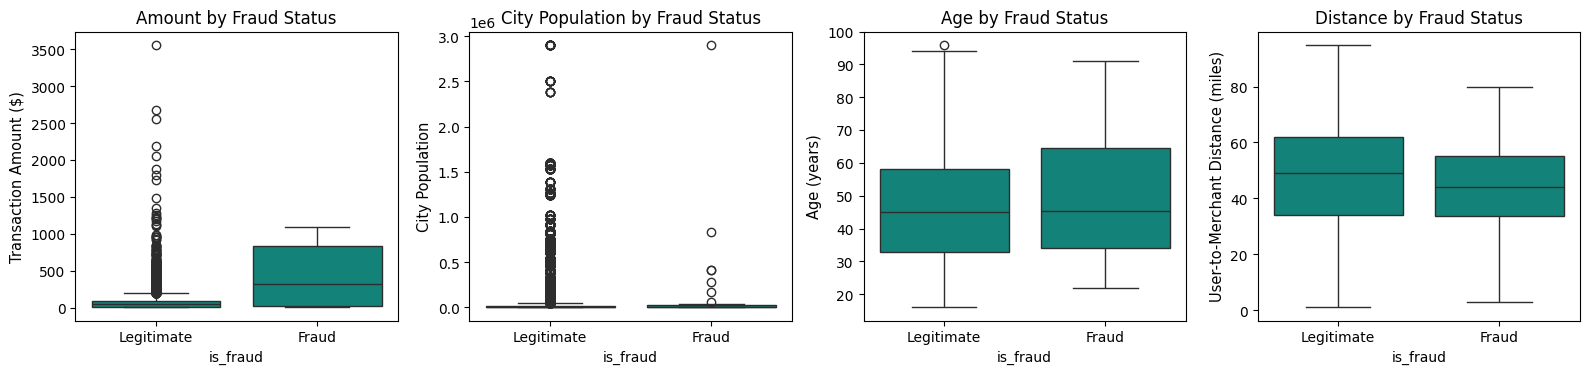

In [55]:
# plot boxplots of quantitative variables
## set figure size
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

## plot histograms
sns.boxplot(stratified_sample, x='is_fraud', y='amt', color='#009688', ax=ax[0])
sns.boxplot(stratified_sample, x='is_fraud', y='city_pop', color='#009688', ax=ax[1])
sns.boxplot(stratified_sample, x='is_fraud', y='age', color='#009688', ax=ax[2])
sns.boxplot(stratified_sample, x='is_fraud', y='distance', color='#009688', ax=ax[3])

## add labels
ax[0].set_title('Amount by Fraud Status', fontsize=12)
ax[0].set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])
ax[0].set_ylabel('Transaction Amount ($)', fontsize=10.5)
ax[1].set_title('City Population by Fraud Status', fontsize=12)
ax[1].set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])
ax[1].set_ylabel('City Population', fontsize=10.5)
ax[2].set_title('Age by Fraud Status', fontsize=12)
ax[2].set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])
ax[2].set_ylabel('Age (years)', fontsize=10.5)
ax[3].set_title('Distance by Fraud Status', fontsize=12)
ax[3].set_xticks(ticks=[0, 1], labels=['Legitimate', 'Fraud'])
ax[3].set_ylabel('User-to-Merchant Distance (miles)', fontsize=10.5)

## set tight layout
plt.tight_layout()

## display plot
plt.show()

__Observations__:

__1. Amount__
- Legitimate transactions predominantly involve small amounts, with a significant number of higher values classified as outliers
- In contrast, fraudulent transactions tend to involve higher-value amounts compared to the non-outlier legitimate transactions
- Notably, several legitimate transactions exceed the upper bound of the fraudulent boxplot

__2. City Population__
- Both legitimate and fraudulent transactions exhibit similar bounds concerning city population
- Each category contains a number of outliers that span a comparable range, although a greater proportion of outliers are found among legitimate transactions
- This suggests that city population may not serve as a particularly effective predictor for determining fraud status unless more complex relationships exist between city characteristics, fraud status, and other predictive features

__3. Age__
- The age boxplots are relatively similar, though the age range for fraudulent transactions is slightly narrower, with legitimate transactions encompassing both younger and older cardholders
- The interquartile range shown in the fraudulent boxplot indicates that the middle 50% of cardholders involved in fraudulent transactions are slightly older than their legitimate counterparts
- While the different interquartile ranges could provide some predictive value for fraud, the overlap between legitimate and fraudulent transactions may complicate its utility as a standalone predictor

__4. Distance__
- The range of user-to-merchant distances for legitimate transactions is broader than that for fraudulent transactions, with legitimate transactions encompassing both shorter and relatively longer distances
- The interquartile range of fraudulent transactions falls within the range for legitimate transactions, suggesting that distance alone may not be a particularly useful predictor for determining fraud status

## Data Preprocessing <a class='anchor' id='preprocess'></a>

[Click Here to Return to Top](#top)

To prepare the data for modeling, it is essential to preprocess it by transforming it into a format compatible with the machine learning algorithms, balancing the classes, and selecting the most informative features. A data pipeline will be employed to streamline this preparation process.

### Custom Transformer: Feature Engineering

The functions developed during the data preparation for Exploratory Data Analysis can be integrated into a single custom transformer. This approach allows for efficient application of these changes to both the training (X_train) and testing (X_test) datasets.

In [56]:
# create custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # no fitting necessary for these transformations
        return self

    def transform(self, df):
        # apply each function in sequence
        ## convert categorical columns currently stored as numbers to 'object' format
        df = convert_to_object(df)
        ## set the transaction number as the index for ease of referencing fraudulent transactions later
        df = set_df_index(df)
        ## extract date and time components
        df = feat_engineer_datetime(df)
        ## extract age
        df = feat_engineer_age(df)
        ## extract user-to-merchant distance
        df = feat_engineer_distance(df)
        ## drop unnecessary columns
        df = prelim_drop_cols(df)
        
        return df

In [57]:
# create instance of FeatureEngineering class
feature_engineering = FeatureEngineering()

After engineering the additional features, the resulting DataFrame is classified into categorical and numeric variables. The subsequent data preprocessing steps will handle these two data types differently, making it essential to differentiate between them.

In [58]:
# define lists of categorical and quantitative variables in the dataset after feature engineering
cat_vars = ['category', 'gender', 'state', 'year', 'month', 'day_of_week', 'time_of_day']
num_vars = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'distance']

### Missing Values

Although the initial exploration of the dataset indicates that there are no null values in the training or test sets, incorporating mechanisms to handle missing data will enhance the robustness of the pipeline. This approach enables the model to manage future data with missing values without requiring manual intervention.

Two of the quantitative variables exhibited skewed distributions. Therefore, the median will be used to substitute any missing numeric data, as it is more resistant to outliers in skewed data. The categorical features will be imputed using the mode, or the most frequent value, for each feature.

In [59]:
# define strategy for imputing missing categorical variables
cat_imputer = SimpleImputer(strategy='most_frequent')

In [60]:
# define strategy for imputing missing numeric variables
num_imputer = SimpleImputer(strategy='median')

### Feature Encoding

Machine learning algorithms typically perform better with numeric inputs; therefore, it is necessary to encode categorical variables to convert them into numeric values.

Two common methods for encoding categorical data are one-hot encoding and ordinal encoding. One-hot encoding is appropriate when categories do not have an inherent order, as it creates binary variables for each category, allowing models to treat them as distinct entities. In contrast, ordinal encoding is useful when categories possess a natural order, such as small, medium, and large.

In this dataset, the categorical variables do not exhibit an inherent order; for example, the list of expense categories is not ranked in any way. Additionally, while features like year, month, day of the week, and time of day have a logical sequence, the relative risk associated with these variables does not appear to correlate with their temporal progression. To prevent suggesting an order where it does not exist and to effectively capture the distinct differences in fraud risk for these features, one-hot encoding will be applied.

One-hot encoding involves creating a binary column for each category represented in each feature, where '1' signifies that the observation belongs to that category and '0' indicates it does not. For instance, if the feature represented transaction types (e.g., grocery, online, gas), all observations for grocery transactions would be coded as '1' in the grocery column and '0' in all other transaction type columns.

This binary nature allows for inferring the value of one category from the others. For example, if there are three categories (A, B, C) and the values for B and C are '0,' it can be inferred that the observation belongs to category A. Therefore, one-hot encoding creates 'n-1' new features for 'n' categories to avoid redundancy. 

In [61]:
# define strategy for encoding categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)

### Column Transformer

The preprocessing steps differ for categorical and quantitative data, and a column transformer allows these steps to be applied to each type of data in parallel. This approach is more efficient than processing each type sequentially. The column transformer will be fitted to the training data and later included in a pipeline to transform the test data.

Many preprocessing pipelines typically include a scaling step for numeric data. However, in this case, scaling is omitted from the preprocessor because the data will first undergo resampling to address class imbalance and feature selection to identify the most relevant features. By performing resampling and feature selection before scaling, we ensure that the synthetic data generated during resampling accurately reflects the raw data's scale and that feature selection retains the inherent relationships between features without distortion from scaling.

In [62]:
# define column transformer
preprocessor = ColumnTransformer(
    transformers = [
        # apply imputation, followed by encoding categorical variables
        ('cat_pipeline', make_pipeline(cat_imputer, encoder), cat_vars),
        # apply imputation to numeric variables
        ('num_pipeline', make_pipeline(num_imputer), num_vars)
    ]
)

### Optimizing Data Types

To ensure the data is as memory-efficient as possible, the following optimization function converts the transformed data (a NumPy array of 'float64' type) to a 'float32' datatype.

In [63]:
# create custom transformer for optimizing datatype
class ConvertFloat64ToFloat32(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # No fitting necessary, just return self
        return self

    def transform(self, X):
        # Convert float64 to float32
        return X.astype('float32')

In [64]:
# create instance of ConvertFloat64ToFloat32 class
convert_to_float32 = ConvertFloat64ToFloat32()

### Preprocessing Pipeline

Data preparation pipelines facilitate the efficient application of the discussed transformations to training data, test data, and any future data. This approach enables the reuse of pipelines without the need to recreate the code each time. The pipeline outlined below consolidates all preprocessing steps conducted prior to resampling the data and performing feature selection.

In [65]:
# create preprocessing pipeline
preprocessing_pipeline = make_pipeline(
    feature_engineering,
    preprocessor,
    convert_to_float32
)

In [66]:
%%time
# fit and transform the training data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)

CPU times: total: 7.72 s
Wall time: 7.04 s


### Class Imbalance Correction

The class imbalance should be addressed before feature selection, as significant imbalance can bias feature importance calculations, making it challenging for the model to prioritize features that aid in identifying the minority class.

Exploratory data analysis suggests that fraudulent transactions in the dataset share certain patterns. Specific categories, such as night and evening in the "time_of_day" feature, exhibit higher relative risk for fraud compared to other categories. Similarly, most quantitative features display boxplots without outliers for the fraud class, indicating that fraudulent activity tends to occur within consistent ranges of these variables.

SMOTE is selected as the class imbalance correction method because it effectively utilizes the similarities between existing fraud cases to generate realistic synthetic samples. By interpolating between minority class instances, SMOTE helps preserve the patterns associated with fraud and enhances the model’s ability to learn from these cases.

To ensure robust model evaluation, a validation set is being established after preprocessing but prior to the application of SMOTE and feature selection. This approach maintains the integrity of the validation process, allowing for an accurate assessment of model performance on unseen data while mitigating the risk of overfitting.

In [67]:
# split X_train into final training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_transformed, 
    y_train,
    # allocate 80% to training and 20% to validation
    test_size=0.2,
    # stratify to ensure proportionate amount of each class in both sets
    stratify=y_train,
    # set random_state for reproducibility
    random_state=42
)

In [68]:
# instantiate SMOTE for resampling
smote = SMOTE()

In [69]:
# apply SMOTE to training data (un-comment to re-run)
## X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

In [70]:
# retrieve SMOTE'd training data
X_train_resampled = loaded_variables['X_train_resampled']
y_train_resampled = loaded_variables['y_train_resampled']

### Feature Selection

A Random Forest Classifier is a machine learning algorithm that generates multiple decision trees to classify observations, such as predicting whether a transaction is 'fraudulent' or 'legitimate.' Each decision tree performs the classification task by applying a series of tests, similar to the structure of a flowchart. 

For instance, a tree might begin by testing the transaction amount. If the tree has learned that transactions over \\$1,000 are more likely to be fraudulent, it could use this as a decision point, dividing transactions into two groups—those less than or equal to \\$1,000 and those greater than \\$1,000, with the latter group predicted as fraudulent. More complex trees include many tests, forming a more intricate branching structure.

The Random Forest Classifier below is used to evaluate feature importance, providing a measure of how much each feature contributes to the model's predictions. These importance values help identify which features have the greatest influence on determining the label attribute.

In [71]:
# instantiate RandomForestClassifier
rf = RandomForestClassifier(
    # limit the number of trees to speed up training
    n_estimators=50,
    # limit tree depth to avoid overfitting and reduce complexity
    max_depth=10,
    # set minimum samples to split a node
    min_samples_split=10,
    # set minimum number of samples per leaf to avoid overly complex trees
    min_samples_leaf=5,
    # use the square root of the number of features for splits
    max_features='sqrt',
    # use all available CPU cores to speed up training
    n_jobs=-1,
    # set random_state for reproducibility
    random_state=42
)

In [72]:
# fit random forest classifier to the SMOTE'd training data (un-comment to re-run)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [73]:
# save feature importances (un-comment to re-run)
## importances = rf.feature_importances_

In [74]:
# retrieve feature importances
importances = loaded_variables['importances']

In [75]:
# save all feature names
## access the encoder inside the categorical pipeline
cat_pipeline = preprocessor.named_transformers_['cat_pipeline']

## access the categorical feature names after one-hot encoding
cat_feature_names = cat_pipeline.named_steps['onehotencoder'].get_feature_names_out(cat_vars)

## combine categorical feature names with numeric feature names
all_feature_names = np.array(list(cat_feature_names) + num_vars)

Next, the distribution of feature importances is plotted on a histogram to evaluate their magnitude and potential skew. This visualization helps inform the approach for selecting features.

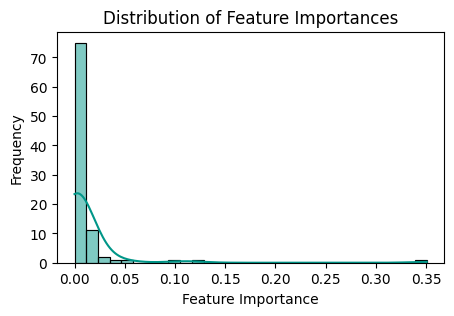

In [76]:
# plot distribution of feature importances
## set figure size
plt.figure(figsize=(5, 3))

## plot histogram
sns.histplot(importances, bins=30, kde=True, color='#009688')

## add labels
plt.title('Distribution of Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')

## display plot
plt.show()

The feature importances range from 0.00 to 0.35, with a pronounced right-skewed distribution, as shown by the histogram. To account for this skewness, SelectFromModel with the median threshold was initially applied. The median, being less sensitive to outliers and skew, offers a more robust central measure for feature selection, leading to 47 features being chosen. However, despite several rounds of hyperparameter tuning, the models exhibited signs of overfitting. To enhance generalization, the number of features is being reduced to 30, focusing on the most relevant predictors to improve performance.

In [77]:
# number of features (after one-hot encoding and other preprocessing) - used as a reference point
print("# Total Features: ", len(all_feature_names))

# Total Features:  93


In [78]:
# sort features by importance in descending order
indices = np.argsort(importances)[::-1]

In [79]:
# select the top 30 features
top_30_indices = indices[:30]

In [80]:
# get the names of the top 30 features
top_30_feature_names = [all_feature_names[i] for i in top_30_indices]

In [81]:
# print the number of features and a list of the features
print('# Selected Features (Top 30): ', len(top_30_feature_names))
print('Selected Features (Top 30): ', top_30_feature_names)

# Selected Features (Top 30):  30
Selected Features (Top 30):  ['amt', 'time_of_day_evening', 'time_of_day_night', 'category_shopping_net', 'time_of_day_morning', 'year_2020', 'category_grocery_pos', 'gender_M', 'day_of_week_6', 'category_gas_transport', 'day_of_week_1', 'category_misc_net', 'month_12', 'category_kids_pets', 'day_of_week_5', 'day_of_week_3', 'day_of_week_4', 'category_health_fitness', 'category_home', 'category_personal_care', 'category_shopping_pos', 'age', 'category_misc_pos', 'category_food_dining', 'category_travel', 'category_grocery_net', 'day_of_week_2', 'month_2', 'month_7', 'month_5']


The selection of 30 features is a substantial reduction from the original 93 features produced during data preprocessing.

The selected features align with trends observed during exploratory data analysis. For example, transaction categories such as 
'shopping_net' and 'grocery_pos,' which exhibited a relative risk higher than the global fraud rate, are included in the final feature set. Similarly, the boxplots comparing fraud status by transaction amount revealed notable distribution differences, an observation validated by the inclusion of 'amt' as a key feature.

A custom transformer is created below to reduce the dataset to these selected features. This can be applied to the training, validation, and test sets, as well as any new data introduced to the model in the future.

In [82]:
# create custom transformer for selecting features
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self):
        # store the top 30 feature indices
        self.top_30_indices = top_30_indices

    def fit(self, X, y=None):
        # no fitting necessary for this transformation
        return self

    def transform(self, array):
        #transform array to select only the top 30 features
        return array[:, self.top_30_indices]

In [83]:
# create instance of FeatureSelection class
feature_selection = FeatureSelection()

### Feature Scaling

Machine learning algorithms may underperform when numerical attributes have widely varying ranges. This can lead to algorithms disproportionately focusing on features with larger values, while underweighting smaller ones.

To mitigate this issue, the data will be scaled using Sci-Kit Learn's MinMaxScaler(), which adjusts each feature to a range between 0 and 1. This adjustment primarily affects numeric data, as categorical features have already been one-hot encoded to values of 0 and 1. The scaler will be integrated into a pipeline alongside the feature selector, ensuring that all variables are on a comparable scale.

In [84]:
# define strategy for feature scaling
scaler = MinMaxScaler()

### Feature Selection & Scaling Pipeline

This pipeline consolidates the feature selection and scaling steps, enabling consistent application across multiple datasets. By streamlining these processes into a single pipeline, it reduces the need for repetitive code and ensures uniform preprocessing for all data used in the machine learning models.

In [85]:
# create feature selection & scaling pipeline
feature_selection_scaling_pipeline = make_pipeline(
    feature_selection,
    scaler
)

### Feature Selection & Scaling Transformation: Training & Validation Data

The training data is both fit and transformed with the feature selection and scaling pipeline because the model needs to learn the scaling parameters (such as minimum and maximum values) and feature selection criteria from the training set. This "fitting" step allows the pipeline to capture the characteristics of the training data. After fitting, the same transformation is applied to the training data to ensure it's prepared for model training.

In contrast, for validation (and test) data, the pipeline only applies the transformation, using the parameters learned from the training data. This ensures that the validation data is treated consistently without influencing the scaling or feature selection process, which must remain independent to provide an unbiased evaluation of the model's performance.

In [86]:
# fit and transform training data using feature selection & scaling pipeline
X_train_scaled = feature_selection_scaling_pipeline.fit_transform(X_train_resampled)

In [87]:
# transform validation data using feature selection & scaling pipeline
X_val_scaled = feature_selection_scaling_pipeline.transform(X_val)

## Shortlist Promising Models <a class='anchor' id='shortlist'></a>

[Click Here to Return to Top](#top)

The following models were developed for evaluation prior to the final model selection:
1. Logistic Regression Classifier
2. XGBoost Classifier
3. Neural Network Classifier

### Model Fitting

First, each model is instantiated, and RandomizedSearchCV is utilized to identify the optimal hyperparameters—configuration settings that influence how the model learns from data and makes predictions. Each section includes a brief description of the model and the corresponding hyperparameters being tuned.

Next, each model is trained using the selected best hyperparameters. The trained models are then used to generate predictions and compute evaluation metrics in the subsequent section.

#### Logistic Regression Model

Logistic regression is a statistical method used for binary classification tasks. It models the probability that a given input belongs to a particular category based on one or more predictor variables. The algorithm applies a logistic function to transform its output into a probability value between 0 and 1, allowing for clear decision boundaries between classes (Hosmer & Lemeshow, 2000).

In [88]:
# instantiate logistic regression class
log_clf = LogisticRegression(
    # starting value for inverse regularization strength
    C=1.0, 
    # random_state for reproducibility
    random_state=42,
    # solver optimized for larger dataset
    solver='saga',
    # starting value uses a higher number of iterations for convergence due dataset size
    max_iter=300          
)

For this model, the following hyperparameters are tuned:
1. 'C': Controls the inverse of the regularization strength.
    - Smaller values increase regularization, which helps reduce overfitting by penalizing overly complex models.
2. 'max_iter': Sets the maximum number of iterations the solver will run to find a solution.
    - Higher values help ensure convergence, particularly for larger datasets.
3. 'class_weight': Manages class imbalance in the dataset.
    - 'balanced': Automatically adjusts weights inversely proportional to class frequencies.
    - 'None': No adjustments to class weights.

In [89]:
# define hyperparameter grid for logistic regression model
log_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'max_iter': [100, 300, 500],
    'class_weight': ['balanced', None]
}

RandomizedSearchCV is used to identify optimal hyperparameters, which influence how the model learns and predicts.

In [90]:
# perform randomized search to tune hyperparameters
log_random_search = RandomizedSearchCV(
    estimator=log_clf,
    param_distributions=log_param_grid,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1 
)

In [91]:
# fit model (un-comment to re-run)
## log_random_search.fit(X_train_scaled, y_train_resampled)

The best parameters are reviewed before saving the model with those settings. Lastly, the optimized model is trained on the full training dataset.

In [92]:
# save best parameters (un-comment to re-run)
## log_best_params = log_random_search.best_params_

In [93]:
# retrieve best parameters
log_best_params = loaded_variables['log_best_params']

In [94]:
# print best parameters
print("Best Logistic Regression Parameters:", log_best_params)

Best Logistic Regression Parameters: {'max_iter': 500, 'class_weight': None, 'C': 100.0}


In [95]:
# save best model (un-comment to re-run)
## best_log_clf = log_random_search.best_estimator_

In [96]:
# train best model (un-comment to re-run)
## best_log_clf.fit(X_train_scaled, y_train_resampled)

In [97]:
# store trained model (un-comment to re-run)
## best_log_clf = joblib.dump(best_log_clf, 'models/best_log_clf.pkl')

In [98]:
# load trained model
best_log_clf = joblib.load('models/best_log_clf.pkl')

The following code generates predictions for both training and validation sets to compute performance metrics. StratifiedKFold conducts cross-validation similar to that used in RandomizedSearchCV, splitting the training and validation data into five subsets. Each subset is utilized to make predictions and compute metrics. The average results are then saved for comparison with other models later.

In [99]:
# define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [100]:
# generate training and validation predictions (binary class for accuracy, precision, recall, and F1) (un-comment to re-run)
## log_train_preds = cross_val_predict(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, method='predict') > 0.5
## log_val_preds = cross_val_predict(best_log_clf, X_val_scaled, y_val, cv=cv, method='predict') > 0.5

In [101]:
# retrieve training and validation predictions
log_train_preds = loaded_variables['log_train_preds']
log_val_preds = loaded_variables['log_val_preds']

In [102]:
# generate training and validation prediction probabilities (probabilities for AUC) (un-comment to to re-run)
## log_train_probs = cross_val_predict(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, method='predict_proba')[:, 1]
## log_val_probs = cross_val_predict(best_log_clf, X_val_scaled, y_val, cv=cv, method='predict_proba')[:, 1]

In [103]:
# retrieve training and validation prediction probabilities
log_train_probs = loaded_variables['log_train_probs']
log_val_probs = loaded_variables['log_val_probs']

In [104]:
# save average cross-validated training metrics (un-comment to re-run)
## log_train_accuracy = cross_val_score(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy').mean()
## log_train_precision = cross_val_score(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='precision').mean()
## log_train_recall = cross_val_score(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='recall').mean()
## log_train_f1 = cross_val_score(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='f1').mean()
## log_train_auc = cross_val_score(best_log_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='roc_auc').mean()

In [105]:
# retrieve average cross-validated validation metrics
log_train_accuracy = loaded_variables['log_train_accuracy']
log_train_precision = loaded_variables['log_train_precision']
log_train_recall = loaded_variables['log_train_recall']
log_train_f1 = loaded_variables['log_train_f1']
log_train_auc = loaded_variables['log_train_auc']

In [106]:
# save average cross-validated validation metrics (un-comment to re-run)
## log_val_accuracy = cross_val_score(best_log_clf, X_val_scaled, y_val, cv=cv, scoring='accuracy').mean()
## log_val_precision = cross_val_score(best_log_clf, X_val_scaled, y_val, cv=cv, scoring='precision').mean()
## log_val_recall = cross_val_score(best_log_clf, X_val_scaled, y_val, cv=cv, scoring='recall').mean()
## log_val_f1 = cross_val_score(best_log_clf, X_val_scaled, y_val, cv=cv, scoring='f1').mean()
## log_val_auc = cross_val_score(best_log_clf, X_val_scaled, y_val, cv=cv, scoring='roc_auc').mean()

In [107]:
# retrieve average cross-validated validation metrics
log_val_accuracy = loaded_variables['log_val_accuracy']
log_val_precision = loaded_variables['log_val_precision']
log_val_recall = loaded_variables['log_val_recall']
log_val_f1 = loaded_variables['log_val_f1']
log_val_auc = loaded_variables['log_val_auc']

#### XGBoost Model

XGBoost (Extreme Gradient Boosting) is an advanced implementation of gradient boosting designed for efficiency and performance. It builds an ensemble of decision trees, optimizing the model through techniques like regularization and parallel processing. This approach allows XGBoost to handle large datasets and complex relationships effectively, making it a popular choice for many classification problems (Chen & Guestrin, 2016).

In [108]:
# instantiate XGBoost class
xgb_clf = XGBClassifier(
    # specify binary classification objective
    objective='binary:logistic',
    # measure performance for a classifier with probability outputs between 0 and 1
    eval_metric='logloss',
    # random_state for reproducibility
    random_state=42
)

For this model, the following hyperparameters are tuned:
1. 'n_estimators': Specifies the number of boosting rounds or trees to be created.
    - A higher number of estimators can enhance model performance by allowing more complex relationships to be captured, but it also increases the risk of overfitting, especially with limited data.
2. 'learning_rate': Controls the step size at each iteration while moving toward a minimum of the loss function.
    - Smaller values lead to more cautious updates, requiring more boosting rounds to converge. This can improve model performance but also increases training time.
3. 'max_depth': Sets the maximum depth of each tree.
    - Deeper trees can capture more complex relationships within the data but may also lead to overfitting. This parameter helps control the model's complexity and generalization ability.
4. 'min_child_weight': Defines the minimum sum of instance weight (hessian) needed in a child.
    - This parameter helps prevent overfitting by ensuring that leaves in the trees contain a minimum amount of data, making the model more robust against noise.
5. 'subsample': Represents the fraction of samples to be used for each tree.
    - Values below 1.0 can prevent overfitting by introducing randomness into the training process. Lower values can lead to faster training times and improved generalization.
6. 'colsample_bytree': Specifies the fraction of features to be used for constructing each tree.
    - This parameter helps improve model robustness and reduces overfitting by ensuring that the model does not rely on any single feature too heavily, allowing for more diverse trees.
7. 'reg_alpha': L1 regularization term on weights.
    - This parameter controls the L1 regularization applied to leaf weights. Increasing reg_alpha can lead to sparser models by penalizing large coefficients, helping prevent overfitting and improve generalization.
8. 'reg_lambda': L2 regularization term on weights.
    - L2 regularization helps control the size of the leaf weights, reducing the likelihood of overfitting. Higher values of reg_lambda encourage smaller weights, making the model less sensitive to small fluctuations in the data.
9. 'gamma': Minimum loss reduction required to make a further partition on a leaf node.
    - Higher values of gamma make the algorithm more conservative by requiring a larger reduction in the loss function before splitting, which helps prevent overfitting by controlling tree complexity.

In [109]:
# define hyperparameter grid for XGBoost model
xgb_param_grid = {
    'n_estimators': [250, 270, 280],  
    'learning_rate': [0.1, 0.15],  
    'max_depth': [5, 6],         
    'min_child_weight': [5, 8],  
    'subsample': [0.8, 0.9, 0.95],     
    'colsample_bytree': [0.8, 0.85],  
    'reg_alpha': [0.15, 0.2],     
    'reg_lambda': [1, 2, 3],      
    'gamma': [0.1, 0.2],           
}

The same RandomizedSearchCV procedure applied to the Logistic Regression model is used to identify optimal hyperparameters for the XGBoost model.

In [110]:
# perform randomized search to tune hyperparameters
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

In [111]:
# fit model (un-comment to re-run)
## xgb_random_search.fit(X_train_scaled, y_train_resampled)

The best parameters are reviewed before saving the model with those settings. Lastly, the optimized model is trained on the full training dataset.

In [112]:
# save best parameters (un-comment to re-run)
## xgb_best_params = xgb_random_search.best_params_

In [113]:
# retrieve best parameters
xgb_best_params = loaded_variables['xgb_best_params']

In [114]:
# print best parameters
print("Best XGBoost Parameters:", xgb_best_params)

Best XGBoost Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.15, 'n_estimators': 270, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.85}


In [115]:
# save best model (un-comment to re-run)
## best_xgb_clf = xgb_random_search.best_estimator_

In [116]:
# train best model (un-comment to re-run)
## best_xgb_clf.fit(X_train_scaled, y_train_resampled)

In [117]:
# store trained model (un-comment to re-run)
## best_xgb_clf = joblib.dump(best_xgb_clf, 'models/best_xgb_clf.pkl')

In [118]:
# load trained model
best_xgb_clf = joblib.load('models/best_xgb_clf.pkl')

The same cross validation procedure applied to the Logistic Regression model is utilized to make predictions and compute metrics for the XGBoost model.

In [119]:
# generate training and validation predictions (binary class for accuracy, precision, recall, and F1) (un-comment to re-run)
## xgb_train_preds = cross_val_predict(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, method='predict') > 0.5
## xgb_val_preds = cross_val_predict(best_xgb_clf, X_val_scaled, y_val, cv=cv, method='predict') > 0.5

In [120]:
# retrieve training and validation predictions
xgb_train_preds = loaded_variables['xgb_train_preds']
xgb_val_preds = loaded_variables['xgb_val_preds']

In [121]:
# generate training and validation prediction probabilities (probabilities for AUC) (un-comment to re-run)
## xgb_train_probs = cross_val_predict(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, method='predict_proba')[:, 1]
## xgb_val_probs = cross_val_predict(best_xgb_clf, X_val_scaled, y_val, cv=cv, method='predict_proba')[:, 1]

In [122]:
# retrieve training and validation prediction probabilities
xgb_train_probs = loaded_variables['xgb_train_probs']
xgb_val_probs = loaded_variables['xgb_val_probs']

In [123]:
# save average cross-validated training metrics (un-comment to re-run)
## xgb_train_accuracy = cross_val_score(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='accuracy').mean()
## xgb_train_precision = cross_val_score(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='precision').mean()
## xgb_train_recall = cross_val_score(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='recall').mean()
## xgb_train_f1 = cross_val_score(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='f1').mean()
## xgb_train_auc = cross_val_score(best_xgb_clf, X_train_scaled, y_train_resampled, cv=cv, scoring='roc_auc').mean()

In [124]:
# retrieve average cross-validated training metrics
xgb_train_accuracy = loaded_variables['xgb_train_accuracy']
xgb_train_precision = loaded_variables['xgb_train_precision']
xgb_train_recall = loaded_variables['xgb_train_recall']
xgb_train_f1 = loaded_variables['xgb_train_f1']
xgb_train_auc = loaded_variables['xgb_train_auc']

In [125]:
# save average cross-validated validation metrics (un-comment to re-run)
## xgb_val_accuracy = cross_val_score(best_xgb_clf, X_val_scaled, y_val, cv=cv, scoring='accuracy').mean()
## xgb_val_precision = cross_val_score(best_xgb_clf, X_val_scaled, y_val, cv=cv, scoring='precision').mean()
## xgb_val_recall = cross_val_score(best_xgb_clf, X_val_scaled, y_val, cv=cv, scoring='recall').mean()
## xgb_val_f1 = cross_val_score(best_xgb_clf, X_val_scaled, y_val, cv=cv, scoring='f1').mean()
## xgb_val_auc = cross_val_score(best_xgb_clf, X_val_scaled, y_val, cv=cv, scoring='roc_auc').mean()

In [126]:
# retrieve average cross-validated training metrics
xgb_val_accuracy = loaded_variables['xgb_val_accuracy']
xgb_val_precision = loaded_variables['xgb_val_precision']
xgb_val_recall = loaded_variables['xgb_val_recall']
xgb_val_f1 = loaded_variables['xgb_val_f1']
xgb_val_auc = loaded_variables['xgb_val_auc']

#### Neural Network Model

Neural networks are a class of machine learning models inspired by the human brain's architecture. They consist of interconnected layers of nodes (neurons) that process input data through nonlinear transformations. By adjusting the weights of connections based on training data, neural networks can capture intricate patterns and relationships in the data, making them well-suited for a wide range of tasks, including classification (Goodfellow, Bengio, & Courville, 2016).

In [127]:
# set random seed for reproducibility with TensorFlow
tf.random.set_seed(42)

In [128]:
# define function to create Keras model
def create_nn_model(units=64, activation='relu', optimizer='adam'):
    # instantiate Sequential object
    model = Sequential()
    # add input layer
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    # add hidden layer
    model.add(Dense(units, activation=activation))
    # add dropout to reduce overfitting
    model.add(Dropout(0.3))
    # add output layer
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')])
    return model

In [129]:
# create KerasClassifier (switch to model=create_nn_model if using an updated version of scikeras)
nn_clf = KerasClassifier(build_fn=create_nn_model,
                         # set default units as 64
                         units=64, 
                         # set 'relu' as default activation
                         activation='relu', 
                         # set 'adam' as default optimizer
                         optimizer='adam',
                         verbose=0)

For this model, the following hyperparameters are tuned:
1. 'model__units': Specifies the number of neurons in each layer of the neural network.
    - Higher values allow the model to learn more complex representations of the data.
    - Excessively large numbers can lead to overfitting, especially in smaller datasets.
2. 'model__activation': Determines the activation function applied to each neuron, influencing how well the model captures complex patterns.
    - Functions like 'relu' introduce non-linearity and help mitigate the vanishing gradient problem.
    - Functions like 'tanh' can provide smoother gradients but may suffer from saturation. 
3. 'optimizer': Defines the optimization algorithm used to update model weights.
    - Algorithms like 'adam' adapt the learning rate based on the average first and second moments of the gradients, providing a balance of speed and performance.
    - The 'rmsprop'algorithm also adjusts learning rates but focuses on maintaining a moving average of the gradients.
4. 'epochs': Represents the number of complete passes through the training dataset.
    - More epochs allow the model to learn more from the data but can lead to overfitting if set too high without proper regularization.
5. 'batch_size': Specifies the number of training examples utilized in one iteration.
    - Smaller batch sizes often provide a more accurate estimate of the gradient and can help in generalization.
    - Larger batch sizes may lead to faster training but can also result in poorer convergence due to noisier gradient estimates.

In [130]:
# define hyperparameter grid for neural network model
nn_param_grid = {
    'units': [32, 64, 128],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10, 15],
    'batch_size': [64, 128]
}

A similar randomized search is performed for the neural network model, with one addition: early stopping. 

Early Stopping is a regularization technique that monitors the model's performance on a validation dataset and halts training when performance begins to decline, instead of continuing for a predetermined number of epochs. The key benefits include:
1. Optimal Model Selection: Training stops when the model reaches its peak performance, ensuring the best possible model is chosen.
2. Time Savings: By terminating training early when an optimal model is identified, resources and time are conserved, enhancing efficiency.
3. Overfitting Reduction: This technique helps prevent the model from learning noise in the training data, promoting better generalization to unseen data.

In [131]:
# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [132]:
# perform randomized search to tune hyperparameters
nn_random_search = RandomizedSearchCV(
    estimator=nn_clf,
    param_distributions=nn_param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1
)

In [133]:
# fit model (un-comment to re-run)
## nn_random_search.fit(X_train_scaled, y_train_resampled, 
##                     validation_data=(X_val_scaled, y_val), 
##                     callbacks=[early_stopping])

The best parameters are reviewed before saving the model with those settings. Lastly, the optimized model is trained on the full training dataset.

In [134]:
# save best parameters (un-comment to re-run)
## nn_best_params = nn_random_search.best_params_

In [135]:
# retrieve best parameters
nn_best_params = loaded_variables['nn_best_params']

In [136]:
# print best parameters
print("Best Neural Network Parameters:", nn_best_params)

Best Neural Network Parameters: {'units': 64, 'optimizer': 'rmsprop', 'epochs': 15, 'batch_size': 64, 'activation': 'relu'}


In [137]:
# save best model (un-comment to re-run)
## best_nn_clf = nn_random_search.best_estimator_

In [138]:
# train best model (un-comment to re-run)
## best_nn_clf.fit(X_train_scaled, y_train_resampled, validation_data=(X_val_scaled, y_val),
##                epochs=best_nn_clf.get_params()['epochs'],
##                batch_size=best_nn_clf.get_params()['batch_size'],
##                callbacks=[early_stopping])

In [139]:
# store trained model (un-comment to re-run)
## best_nn_clf = joblib.dump(best_nn_clf, 'models/best_nn_clf.pkl')

In [140]:
# load trained model
best_nn_clf = joblib.load('models/best_nn_clf.pkl')

Neural network predictions and metrics are computed using the entire training and validation sets. While cross-validation enhances the ability to evaluate a model's generalization performance, it is less commonly applied to neural networks due to their high computational demands and extended training times. Consequently, omitting the cross-validation step for neural networks is a reasonable compromise, balancing the practicality of training with effective performance evaluation.

In [141]:
# generate training and validation predictions (for accuracy, precision, recall, and F1) (un-comment to re-run)
## nn_train_preds = best_nn_clf.predict(X_train_scaled) > 0.5
## nn_val_preds = best_nn_clf.predict(X_val_scaled) > 0.5

In [142]:
# retrieve training and validation predictions
nn_train_preds = loaded_variables['nn_train_preds']
nn_val_preds = loaded_variables['nn_val_preds']

In [143]:
# generate training and validation prediction probabilities (for AUC) (un-comment to re-run)
## nn_train_probs = best_nn_clf.predict(X_train_scaled).flatten()
## nn_val_probs = best_nn_clf.predict(X_val_scaled).flatten()

In [144]:
# retrieve training and validation prediction probabilities
nn_train_probs = loaded_variables['nn_train_probs']
nn_val_probs = loaded_variables['nn_val_probs']

In [145]:
# save training metrics (un-comment to re-run)
## nn_train_accuracy = accuracy_score(y_train_resampled, nn_train_preds)
## nn_train_precision = precision_score(y_train_resampled, nn_train_preds, pos_label=1)
## nn_train_recall = recall_score(y_train_resampled, nn_train_preds, pos_label=1)
## nn_train_f1 = f1_score(y_train_resampled, nn_train_preds, pos_label=1)
## nn_train_auc = roc_auc_score(y_train_resampled, nn_train_probs)

In [146]:
# retrieve training metrics
nn_train_accuracy = loaded_variables['nn_train_accuracy']
nn_train_precision = loaded_variables['nn_train_precision']
nn_train_recall = loaded_variables['nn_train_recall']
nn_train_f1 = loaded_variables['nn_train_f1']
nn_train_auc = loaded_variables['nn_train_auc']

In [147]:
# save validation metrics (un-comment to re-run)
## nn_val_accuracy = accuracy_score(y_val, nn_val_preds)
## nn_val_precision = precision_score(y_val, nn_val_preds, pos_label=1)
## nn_val_recall = recall_score(y_val, nn_val_preds, pos_label=1)
## nn_val_f1 = f1_score(y_val, nn_val_preds, pos_label=1)
## nn_val_auc = roc_auc_score(y_val, nn_val_probs)

In [148]:
# retrieve validation metrics
nn_val_accuracy = loaded_variables['nn_val_accuracy']
nn_val_precision = loaded_variables['nn_val_precision']
nn_val_recall = loaded_variables['nn_val_recall']
nn_val_f1 = loaded_variables['nn_val_f1']
nn_val_auc = loaded_variables['nn_val_auc']

### Model Comparison

As mentioned in the introduction, each model can make four types of predictions: True Positive, True Negative, False Positive, and False Negative. Confusion matrices visually display the number of predictions in each category.

AUC (Area Under the Curve) graphs depict the performance of a classification model by illustrating the trade-off between true positive and false positive rates across various thresholds. A random model would follow the diagonal line, while a "good" model will have a curve that bows far above the diagonal, indicating better predictive performance.

Below, confusion matrices and AUC curves are generated for each model, along with comments on the results.

In [149]:
# calculate confusion matrices
log_confusion = confusion_matrix(y_val, log_val_preds)
xgb_confusion = confusion_matrix(y_val, xgb_val_preds)
nn_confusion = confusion_matrix(y_val, nn_val_preds)

In [150]:
# define labels
labels = ['Legitimate', 'Fraudulent']

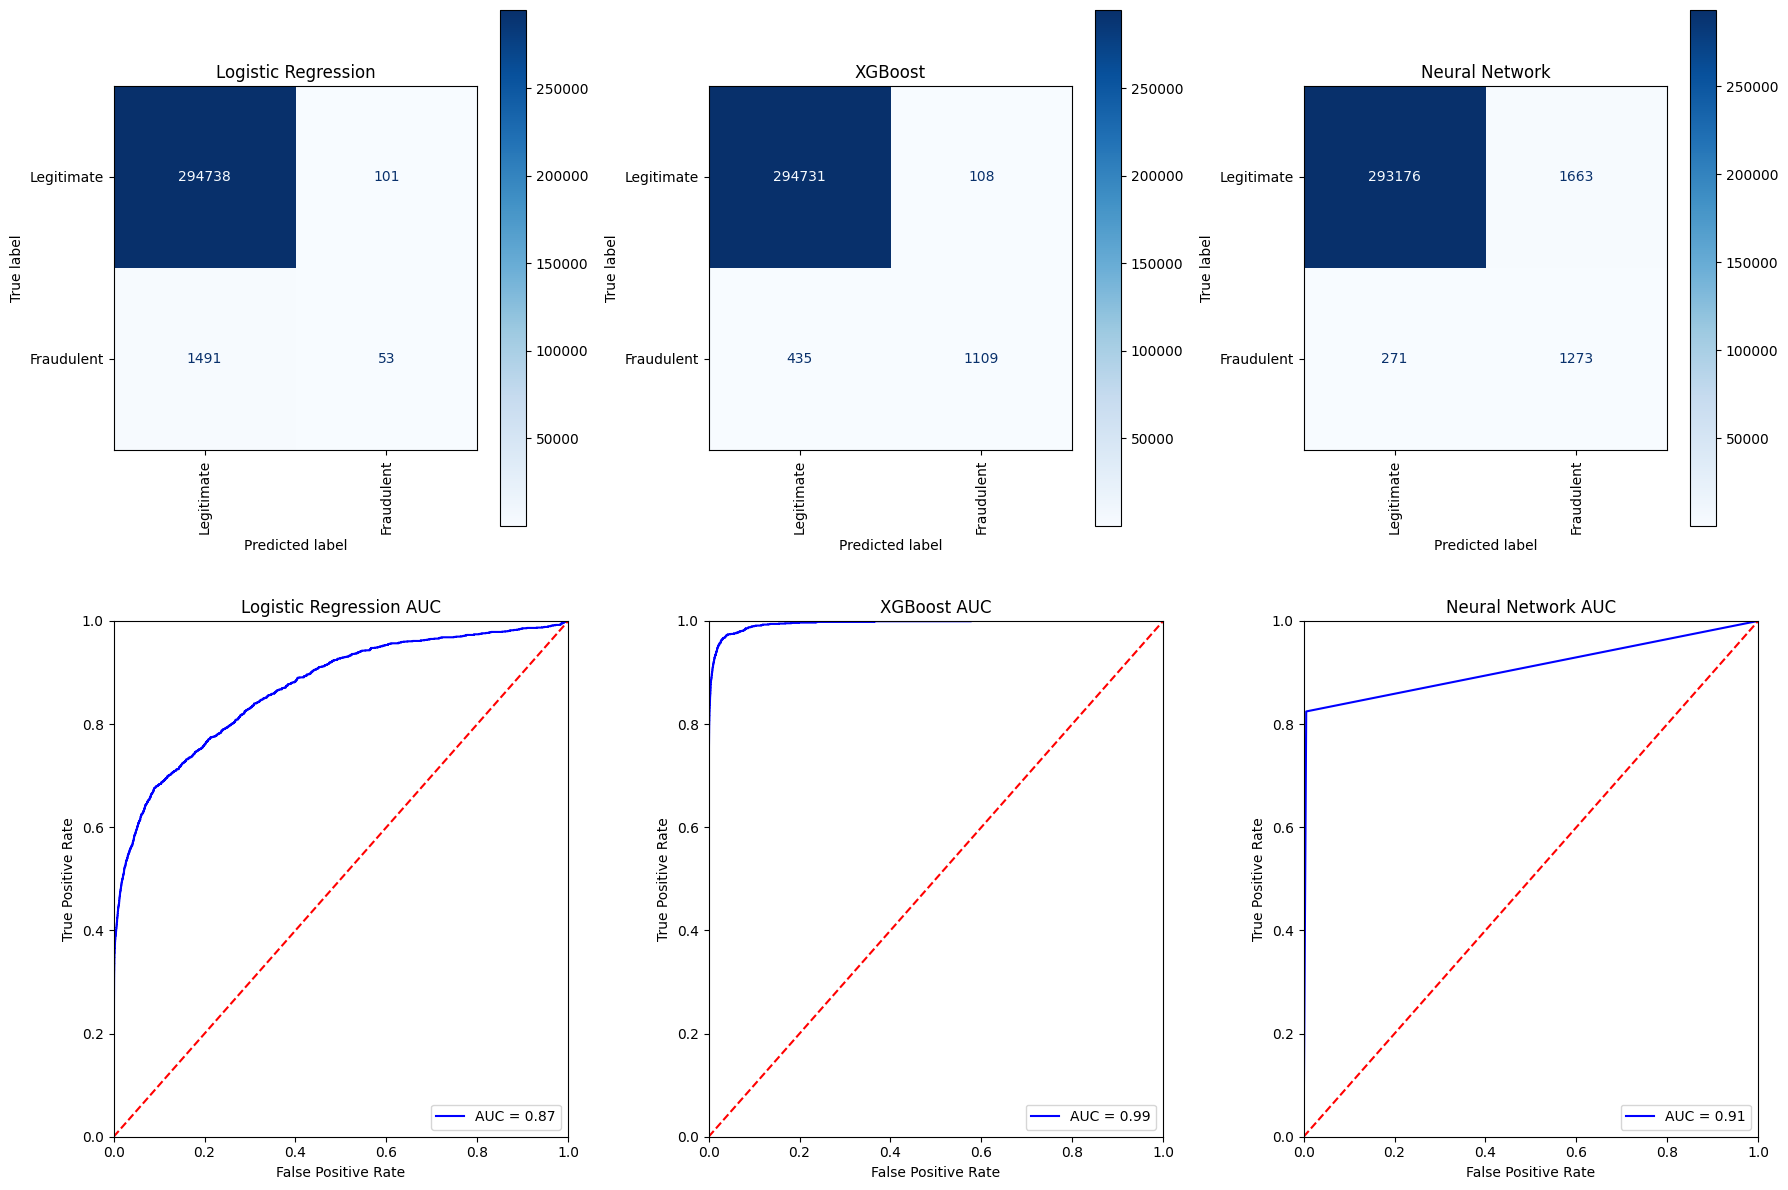

In [151]:
# plot confusion matrices and AUC curves for all three models
## set figure size
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

## plot confusion matrix for Logistic Regression
cmd(confusion_matrix=log_confusion, display_labels=labels).plot(ax=axes[0, 0], cmap='Blues', xticks_rotation='vertical')
axes[0, 0].set_title('Logistic Regression')

## plot confusion matrix for XGBoost
cmd(confusion_matrix=xgb_confusion, display_labels=labels).plot(ax=axes[0, 1], cmap='Blues', xticks_rotation='vertical')
axes[0, 1].set_title('XGBoost')

## plot confusion matrix for Neural Network
cmd(confusion_matrix=nn_confusion, display_labels=labels).plot(ax=axes[0, 2], cmap='Blues', xticks_rotation='vertical')
axes[0, 2].set_title('Neural Network')

## define function to plot AUC curves
def plot_auc_curve(ax, y_true, y_probs, title):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

## plot AUC curve for Logistic Regression
plot_auc_curve(axes[1, 0], y_val, log_val_probs, 'Logistic Regression AUC')

## plot AUC curve for XGBoost
plot_auc_curve(axes[1, 1], y_val, xgb_val_probs, 'XGBoost AUC')

## plot AUC curve for Neural Network
plot_auc_curve(axes[1, 2], y_val, nn_val_probs, 'Neural Network AUC')

## set tight layout
plt.tight_layout()

## display plot
plt.show()

__Observations:__

1. The three confusion matrices demonstrate strong performance in identifying true positives (legitimate predictions of actual legitimate transactions), which is expected given the class imbalance in the dataset.
2. The logistic regression model struggles significantly with true negatives, correctly identifying only 53, while misclassifying 1,491 fraudulent transactions as legitimate (false negatives).
3. The neural network model outperforms logistic regression in identifying true positives, correctly predicting 1,273; however, it has a higher number of total false positives and false negatives, including 1,663 legitimate transactions misclassified as fraudulent.
4. The XGBoost model exhibits the best performance overall, correctly identifying 1,109 true positives and minimizing false predictions (108 false positives and 435 false negatives).
5. The AUC curves reinforce that the XGBoost model is the most effective, as its curve hugs the left and upper sides of the graph, maximizing the area between the curve and the diagonal line representing random predictions. In contrast, the AUC curves for the other two models are closer to the diagonal, indicating weaker performance and less effective discrimination between classes.

As outlined in the introduction, the models will be evaluated using accuracy, precision, recall, F1 score, and AUC-ROC. A comparison table of these metrics for all three models is provided below, followed by comments on the results.

In [152]:
# save a summary of metrics
train_val_summary = {
    'Model': ['Logistic Regression', 'XGBoost', 'Neural Network'],
    'Train Accuracy': [log_train_accuracy, xgb_train_accuracy, nn_train_accuracy],
    'Val Accuracy': [log_val_accuracy, xgb_val_accuracy, nn_val_accuracy],
    'Train Precision': [log_train_precision, xgb_train_precision, nn_train_precision],
    'Val Precision': [log_val_precision, xgb_val_precision, nn_val_precision],
    'Train Recall': [log_train_recall, xgb_train_recall, nn_train_recall],
    'Val Recall': [log_val_recall, xgb_val_recall, nn_val_recall],
    'Train F1': [log_train_f1, xgb_train_f1, nn_train_f1],
    'Val F1': [log_val_f1, xgb_val_f1, nn_val_f1],
    'Train AUC': [log_train_auc, xgb_train_auc, nn_train_auc],
    'Val AUC': [log_val_auc, xgb_val_auc, nn_val_auc],
}

In [153]:
# save summary as a DataFrame
train_val_df = pd.DataFrame(train_val_summary)

In [154]:
# view summary of metrics
train_val_df

,Model,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Train AUC,Val AUC
0,Logistic Regression,0.85,0.99,0.86,0.32,0.82,0.03,0.84,0.06,0.94,0.87
1,XGBoost,1.00,1.00,1.00,0.91,1.00,0.72,1.00,0.80,1.00,0.99
2,Neural Network,0.99,0.99,0.99,0.43,0.99,0.82,0.99,0.57,0.99,0.91


__Observations:__

__1. High Training Metrics__

All three models demonstrate high training metrics, which is expected due to class imbalance and the tendency of machine learning models to memorize patterns in training data. Therefore, validation metrics are critical for model selection.

__2. Reported Accuracy of 1.00__

The XGBoost model shows a reported validation accuracy of 1.00, but erroneous predictions are evident in the confusion matrices. This accuracy rounds up from a value very close to 1.00, indicating that while the model performs exceptionally well, it is not perfectly accurate.

__3. Validation Metrics Align__

Validation metrics confirm the XGBoost model's superior performance, achieving a high precision of 0.91 and a recall of 0.72, demonstrating effective detection of fraud while maintaining high accuracy. The F1 score of 0.80 reflects a balanced performance, considering both metrics, which is essential given the customer base's preference for uninterrupted service.

__4. Outstanding AUC Score__

The AUC score of 0.99 underscores the XGBoost model's effectiveness in distinguishing between classes. In contrast, the other two models exhibit low precision (0.32 and 0.43) and poor F1 scores (0.06 and 0.57), reinforcing the findings from the confusion matrices regarding higher false prediction rates.

Following the evaluation of the metrics, an ensemble modeling approach was explored to leverage insights from both the XGBoost and neural network models. Ensemble modeling aims to improve predictive performance by combining multiple models. However, after testing various weighting variations, this approach did not outperform the XGBoost model. Consequently, the XGBoost model is selected as the final model and will be applied to the test data to confirm its viability for deployment.

### Data Transformation: Test Data

With the model selected, the next step is to test its performance on unseen data.

First, the test data is processed to match the format expected by the model. The model then makes predictions, and the results are evaluated using the metrics outlined in the introduction.

In [155]:
# create pipeline to preprocess test data and future data
## using Pipeline with fitted components so that the full_pipeline does not need to be fitted
full_pipeline = Pipeline([
    # apply initial preprocessing steps
    ('preprocessing', preprocessing_pipeline),
    # apply feature selection and scaling
    ('feature_selection_scaling', feature_selection_scaling_pipeline),
    # include final model
    ('model', best_xgb_clf)
])

In [156]:
# make predictions for test data
test_preds = full_pipeline.predict(X_test)

In [157]:
# calculate metrics
test_accuracy = accuracy_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_preds)

In [158]:
# print validation metrics
print(f"Test Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"AUC: {test_auc:.2f}")

Test Metrics:
Accuracy: 1.00
Precision: 0.81
Recall: 0.84
F1 Score: 0.82
AUC: 0.92


The test metrics demonstrate that the XGBoost model performs well, achieving high precision (0.81) and recall (0.84) on previously unseen data. The F1 score (0.82) reflects a strong balance between precision and recall, indicating that the model is effectively identifying fraudulent transactions without generating excessive false positives. The AUC score of 0.92 suggests that the model has excellent discriminatory ability, accurately distinguishing between legitimate and fraudulent transactions.

## Conclusion <a class='anchor' id='conclusion'></a>

[Click Here to Return to Top](#top)

In an era where fraud opportunities are increasingly prevalent due to the widespread storage of credit card information in digital formats, the need for robust fraud detection solutions has never been more critical. This project focused on the development of a fraud detection model that effectively identifies fraudulent transactions while prioritizing seamless customer service.

The XGBoost model has demonstrated impressive performance on unseen data, achieving high precision (0.81) and recall (0.84), along with a balanced F1 score of 0.82. The model’s AUC score of 0.92 indicates its strong capability to accurately differentiate between legitimate and fraudulent transactions. Given these promising test metrics and the model's alignment with the organization's commitment to uninterrupted service, it is recommended to proceed with the deployment of the XGBoost model. This proactive approach will enhance fraud detection capabilities while maintaining the high-quality customer experience that the user base values.

## Reflections <a class='anchor' id='reflections'></a>

[Click Here to Return to Top](#top)

__Upon reflection, several areas for improvement emerged during the course of this project:__

__1. Proactive Code Organization:__

Implementing a structured approach for saving variables and models (using tools like pickle and joblib) from the outset will enhance efficiency in future projects. This strategy minimizes redundant runs of lengthy training and tuning processes, enabling more streamlined workflows.

__2. Enhanced Data Presentation:__

Developing additional appendices for extensive exploratory data analysis (EDA) will contribute to a more concise and focused main report. This approach ensures that critical insights are easily accessible, improving communication with stakeholders.

__3. Concurrent Validation Set Management:__

By splitting the validation set concurrently with the initial train/test split in future analyses, the efficiency of model evaluation will be significantly improved. This adjustment will facilitate a more robust validation process.

__4. Utilizing Dimensionality Reduction Techniques:__ 

Incorporating Principal Component Analysis (PCA) in future projects can improve computational efficiency and model performance. This technique will allow for a more effective handling of high-dimensional data.

__5. Exploration of Advanced Hyperparameter Tuning:__

Continuing to learn and implement more efficient hyperparameter tuning methods will enhance model optimization. This commitment to developing expertise in this area will save time and improve overall performance.

__6. Adopting Batch Training Strategies:__

Learning to train and tune models in batches will allow for the aggregation of insights regarding feature selection and optimal hyperparameters. This approach will enhance both generalization and the efficiency of the modeling process.

## References <a class='anchor' id='references'></a>

[Click Here to Return to Top](#top)

Chawla, N. V., De Santo, S., & Davis, D. (2004). SMOTE: synthetic minority over-sampling technique. Journal of Artificial Intelligence Research, 16, 321-357. https://doi.org/10.1613/jair.1410

Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785-794). ACM. https://doi.org/10.1145/2939672.2939785

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT Press. http://www.deeplearningbook.org/

Hosmer, D. W., & Lemeshow, S. (2000). Applied logistic regression (2nd ed.). John Wiley & Sons.

Robusto, C. C. (1957). The cosine-haversine formula. The American Mathematical Monthly, 64(1), 38-40.

Shenoy, Kartik. (2020, August 5). *Credit Card Transactions Fraud Detection Dataset.* Kaggle. https://www.kaggle.com/datasets/kartik2112/fraud-detection

Stevens, W. R. (1998). *Unix network programming, volume 1: The sockets networking API (2nd ed.)*. Prentice Hall.

## Appendices <a class='anchor' id='appendices'></a>

[Click Here to Return to Top](#top)

### Appendix A: Saved Variables <a class='anchor' id='appendix_a'></a>

This appendix contains the code used to save variables generated during the more computationally intensive stages of the project, ensuring efficiency for future runs. For quick reference, you can view the code used to load the saved .pkl file by clicking [here](#main_a).

In [159]:
# create a list of variables to store
stored_var_names = ['X_train_resampled', 'y_train_resampled', 'importances', 
                    'log_best_params', 'log_train_preds', 'log_train_probs', 'log_val_preds', 'log_val_probs',
                    'log_train_accuracy', 'log_train_precision', 'log_train_recall', 'log_train_f1', 'log_train_auc', 
                    'log_val_accuracy', 'log_val_precision', 'log_val_recall', 'log_val_f1', 'log_val_auc', 
                    'xgb_best_params', 'xgb_train_preds', 'xgb_train_probs', 'xgb_val_preds', 'xgb_val_probs',
                    'xgb_train_accuracy', 'xgb_train_precision', 'xgb_train_recall', 'xgb_train_f1', 'xgb_train_auc', 
                    'xgb_val_accuracy', 'xgb_val_precision', 'xgb_val_recall', 'xgb_val_f1', 'xgb_val_auc', 
                    'nn_best_params', 'nn_train_preds', 'nn_train_probs', 'nn_val_preds', 'nn_val_probs',
                    'nn_train_accuracy', 'nn_train_precision', 'nn_train_recall', 'nn_train_f1', 'nn_train_auc', 
                    'nn_val_accuracy', 'nn_val_precision', 'nn_val_recall', 'nn_val_f1', 'nn_val_auc']

In [160]:
# use globals() to retrieve values and create a dictionary
variables_to_save = {name: globals()[name] for name in stored_var_names}

In [161]:
# save dictionary to a .pkl file
with open('stored_variables.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)

### Appendix B: Cross Tabulations <a class='anchor' id='appendix_b'></a>

This appendix contains detailed cross tabulations of categorical variables against the 'is_fraud' label, highlighting rows where the relative risk exceeds 1, indicating a higher likelihood of fraud. To view excerpts of these cross tabulations, click [here](#main_b) for easy reference.

In [162]:
# define function to highlight rows with a relative risk greater than the global fraud rate
def highlight_rr_gt_1(row):
    return ['background-color: yellow' if row['Relative Risk'] > 1 else '' for _ in row]

In [163]:
# create cross tabulations for each categorical variable with less than 15 distinct categories
## loop through relevant variables, returning a cross tabulation
for feature in cat_less_than_15:
    # create crosstab using the previously defined function
    appendix_cross_tab = create_crosstab(cc_transactions_train, feature, 'is_fraud')
    
    # highlight categories with relative risk > 1
    display(appendix_cross_tab.style.apply(highlight_rr_gt_1, axis=1))
    print()

is_fraud,0,1,Fraud %,Relative Risk
category,,,,
entertainment,107203,233,0.216873,0.416252
food_dining,104534,157,0.149965,0.287833
gas_transport,149802,635,0.422104,0.810156
grocery_net,51693,142,0.273946,0.525793
grocery_pos,139253,1759,1.247412,2.394195
health_fitness,97943,145,0.147826,0.283728
home,140040,205,0.146173,0.280554
kids_pets,129094,249,0.192511,0.369493
misc_net,71372,969,1.339489,2.570923


is_fraud,0,1,Fraud %,Relative Risk
month,,,,
1,83070,676,0.807203,1.549289
2,77330,666,0.853890,1.638897
3,113995,742,0.646696,1.241224
4,107388,537,0.497568,0.954997
5,116692,762,0.648765,1.245194
6,138585,661,0.474699,0.911105
7,137576,524,0.379435,0.728261
8,140331,637,0.451876,0.867299
9,111696,605,0.538731,1.034002


is_fraud,0,1,Fraud %,Relative Risk
day_of_week,,,,
0,294461,1173,0.396774,0.761541
1,215149,1030,0.476457,0.914478
2,146146,897,0.610026,1.170841
3,164269,1059,0.640545,1.229417
4,170942,1096,0.637069,1.222745
5,209691,1193,0.565714,1.085792
6,273536,1273,0.463231,0.889093


is_fraud,0,1,Fraud %,Relative Risk
time_of_day,,,,
night,288067,2730,0.938799,1.801866
morning,289582,289,0.099700,0.191356
afternoon,448279,453,0.100951,0.193759
evening,448266,4249,0.938974,1.802202


is_fraud,0,1,Fraud %,Relative Risk
gender,,,,
F,807322,3934,0.484927,0.930735
M,666872,3787,0.564668,1.083785


is_fraud,0,1,Fraud %,Relative Risk
year,,,,
2019,735730,4165,0.562918,1.080425
2020,738464,3556,0.479232,0.919805
